#Predicting Restaurant Success by Neighborhood Factors Using the Yelp Dataset#

### Alexander Goldberg, Brian de Luna, Gabriela Merz, and Daniel Smith  ###

![my_image](img/yelp.png)

Will a Chinese restaurant be more successful in Harvard Square or Central Square? How about Allston?

Our project predicts the Yelp rating of a restaurant by examining the Yelp data of the surrounding neighborhood. Previously, we have predicted the Yelp rating by looking at the ratings of similar users to the rater and similar restaurants to the subject of the rating. In that analysis, our 'neighborhood' consisted of similar users and restaurants. In this project, we want to look at the physical neighborhood; we are examining the characteristics of the restaurants that surround the subject of the review, and use this to predict the rating of the subject.

Our basic hypothesis guiding our predictive models is that a restaurant's success and quality as reflected in its star rating on Yelp is influenced by the quality and characteristics of the surrounding restaurants.

We use the Yelp Academic Dataset, a collection of data made avaible by Yelp as part of a competition called the Yelp Dataset Challenge which we plan to submit to as well. The data contains information about restaurants in 7 cities, including their locations, their star ratings, and attributes like alcohol availability, open and closing times, and categories the restaurant belongs to. We specifically focus on data from the Phoenix, AZ metro area, as this was the city with the most data in the dataset. More information about the dataset can be found here: https://www.yelp.com/academic_dataset.

We start by exploring the data before moving into our predictions. In our predictions, we will make our baseline models based on the ratings of the nearest restaurants, then use a simple ridge regression using neighborhood indicators (to explain the features of the neighborhood) to see how the neighborhood affects restaurant rating. After that, we will use the random forest method to pick out better neighborhood features, and use those in a more complex ridge regression. We then use AdaBoost and Decision Tree regressors, which both choose the weights that we will use on each variable in slightly different ways. It will be interesting to see what features are chosen through each method, and why. Finally, we will use an ensemble method to put it all together.

Ultimately, we used these models to build an interactive visualization on our website using the Google Maps API which enables users to drag a marker representing a restaurant with user-inputted characteristics to a location in the Phoenix Metro Area and to use a specified predictive model that we built to predict the star rating of that restaurant in the neighborhood in which it is placed.

#Table of Contents
* [Predicting Restaurant Success by Neighborhood Factors Using the Yelp Dataset](#Predicting-Restaurant-Success-by-Neighborhood-Factors-Using-the-Yelp-Dataset)
	* [1. Setting Up the Data](#Setting-Up-the-Data)
		* [Splitting Up By City](#Splitting-Up-By-City)
		* [Choosing Which Categories to Use](#Choosing-Which-Categories-to-Use)
	* [2. Exploratory Data Analysis](#Exploratory-Data-Analysis)
		* [Star Ratings](#Star-Ratings)
		* [Prices](#Prices)
        * [Opening and Closing Times](#Opening-and-Closing-Times)
        * [Interactive Plot Using Boquet](#Interactive-Plot-Using-Boquet)
	* [3. Finding Neighbors](#Finding-Neighbors)
    * [4. Building Models](#Building-Models)	
        * [Baseline Model 1](#Baseline-Model-1)
        * [Baseline Model 2 and Local Recommender](#Baseline-Model-2-and-Local-Recommender)
        * [Ridge Regression - Using Neighbor Indicators](#Ridge-Regression---Using-Neighbor-Indicators)
            * [Forming a Matrix](#Forming-a-Matrix)
        * [Gauging Feature Importance through Random Forest](#Gauging-Feature-Importance-through-Random-Forest)
            * [Formatting a Dataframe](#Formatting-a-Dataframe)
        * [Ridge Regression - Using Neighborhood Attributes](#Ridge-Regression---Using-Neighborhood-Attributes)
        * [Get at me AdaBoost](#Get-at-me-AdaBoost)
    * [5. Ensemble Method: Blending Local, Simple Ridge, & Complex Ridge](#Ensemble-Method:-Blending-Local,-Simple-Ridge,-&-Complex-Ridge)


## Setting Up the Data ##

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import json

In [2]:
# need to pip install matplotlib_venn
from matplotlib_venn import venn2

In [3]:
businesses = []
with open("yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_business.json", "r") as json_file:
    for line in json_file:
        businesses += [json.loads(line)]

Here is our data frame straight from the Yelp public data set.

In [4]:
businessdf = pd.DataFrame(businesses)
businessdf.head()

,attributes,business_id,categories,city,full_address,hours,latitude,longitude,name,neighborhoods,open,review_count,stars,state,type
0,{u'By Appointment Only': True},vcNAWiLM4dR7D2nwwJ7nCA,"[Doctors, Health & Medical]",Phoenix,"4840 E Indian School Rd\nSte 101\nPhoenix, AZ ...","{u'Thursday': {u'close': u'17:00', u'open': u'...",33.499313,-111.983758,"Eric Goldberg, MD",[],True,9,3.5,AZ,business
1,"{u'Happy Hour': True, u'Accepts Credit Cards':...",UsFtqoBl7naz8AVUBZMjQQ,[Nightlife],Dravosburg,"202 McClure St\nDravosburg, PA 15034",{},40.350519,-79.886930,Clancy's Pub,[],True,4,3.5,PA,business
2,{u'Good for Kids': True},cE27W9VPgO88Qxe4ol6y_g,"[Active Life, Mini Golf, Golf]",Bethel Park,"1530 Hamilton Rd\nBethel Park, PA 15234",{},40.356896,-80.015910,Cool Springs Golf Center,[],False,5,2.5,PA,business
3,{},HZdLhv6COCleJMo7nPl-RA,"[Shopping, Home Services, Internet Service Pro...",Pittsburgh,"301 S Hills Vlg\nPittsburgh, PA 15241","{u'Monday': {u'close': u'21:00', u'open': u'10...",40.357620,-80.059980,Verizon Wireless,[],True,3,3.5,PA,business
4,"{u'Alcohol': u'full_bar', u'Noise Level': u'av...",mVHrayjG3uZ_RLHkLj-AMg,"[Bars, American (New), Nightlife, Lounges, Res...",Braddock,"414 Hawkins Ave\nBraddock, PA 15104","{u'Tuesday': {u'close': u'19:00', u'open': u'1...",40.408735,-79.866351,Emil's Lounge,[],True,11,4.5,PA,business


In [5]:
print "Open: " + str(businessdf[businessdf["open"]].shape[0])
print "Closed: " + str(businessdf[np.negative(businessdf["open"])].shape[0])

Open: 53725
Closed: 7459


Some of the restaurants have closed, so we won't use them.

In [6]:
# Only use open restaurants
businessdf = businessdf[businessdf["open"]]

### Splitting Up By City ###

The data set has business in many different cities and states. Here are the states that have a significant number of businesses. We will remove any places with less than 5 businesses because they are insignificant in the scope of this dataset. We will also pick out businesses that are in metro areas and see which cities have show up in this data set significantly.

In [7]:
grouped = businessdf.groupby("state")
states = grouped.count().business_id
states_touse = states[states >= 5]
states_touse

state
AZ     21927
BW       910
EDH     2625
ELN        7
IL       532
MLN      119
NC      4368
NV     14435
ON       328
PA      2670
QC      3627
RP        13
SC       157
WI      1989
Name: business_id, dtype: int64

In [8]:
# The metro area that each state abbreviation corresponds to
abbrevs = {"AZ" : "Phoenix", 
           "BW": "Karlsruhe", "RP" : "Karlsruhe",
           "EDH" : "Edinburgh", "MLN" : "Edinburgh","ELN" : "Edinburgh", 
           "IL" : "Urbana-Champaign",
           "NC" : "Charlotte", "SC" : "Charlotte",
           "NV" : "Las Vegas",
           "ON" : "Waterloo",
           "PA" : "Pittsburgh",
           "QC" : "Montreal",
           "WI" : "Madison"}

In [9]:
# Remove any businesses in states with less than 5 businesses (removed 18 businesses)
businessdf = businessdf[[state in states_touse for state in businessdf.state]]

# Add column for metro area that business is in
businessdf.is_copy = False
businessdf["metro"] = businessdf.state.map(lambda s : abbrevs[s])

print businessdf.shape

(53707, 16)


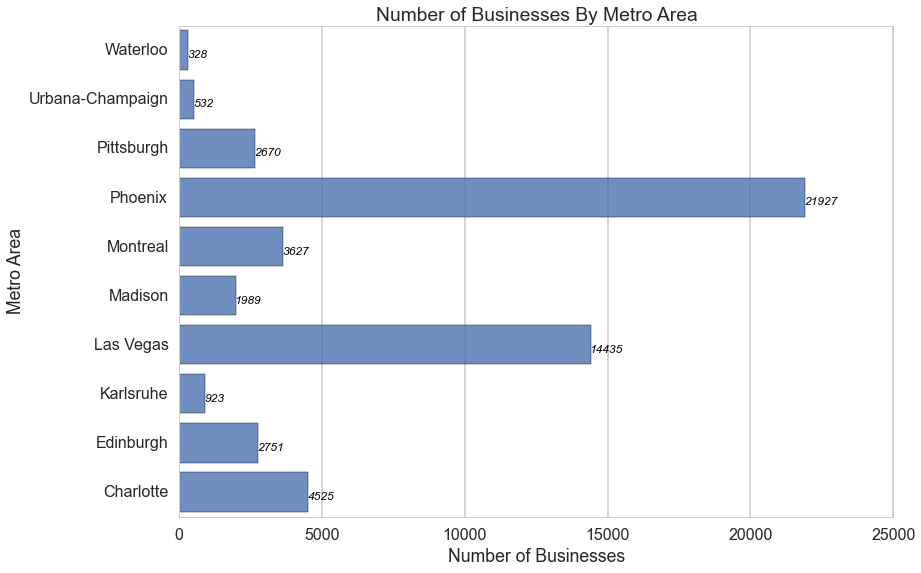

In [10]:
metro_counts = businessdf.groupby("metro").count()
Y = np.arange(len(metro_counts.index))
bars = plt.barh(Y, metro_counts.business_id, align = 'center', alpha = 0.8)
plt.yticks(Y, metro_counts.index)
plt.ylim(-0.5,9.5)
plt.xlabel("Number of Businesses")
plt.ylabel("Metro Area")
plt.title("Number of Businesses By Metro Area")
plt.grid(b=None, axis='y')
font = {'color':  'black','size': 12}
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + 0.25, bar.get_width(), fontdict=font, style='italic')

It looks like the data set has lots of businesses in Phoenix and Las Vegas, followed by several other U.S. cities and several international cities.

### Choosing Which Categories to Use ###

With a data set that has so many points, we should look at the categories that the businesses are spread over and figure out which categories are most prevalent. We will display the 50 most prevalent categories so that we can get a better idea of what businesses populate our data set. We will only use categories that are represented with a significant number of businesses in our data set.

In [11]:
# Get the number and indexes of restaurants in each category
ccounts = {}
csets = {}
for i, clist in businessdf.categories.iteritems():
    for c in clist:
        if c not in ccounts.keys():
            ccounts[c] = 1
            csets[c] = set([i])
        else:
            ccounts[c] += 1
            csets[c].update([i])

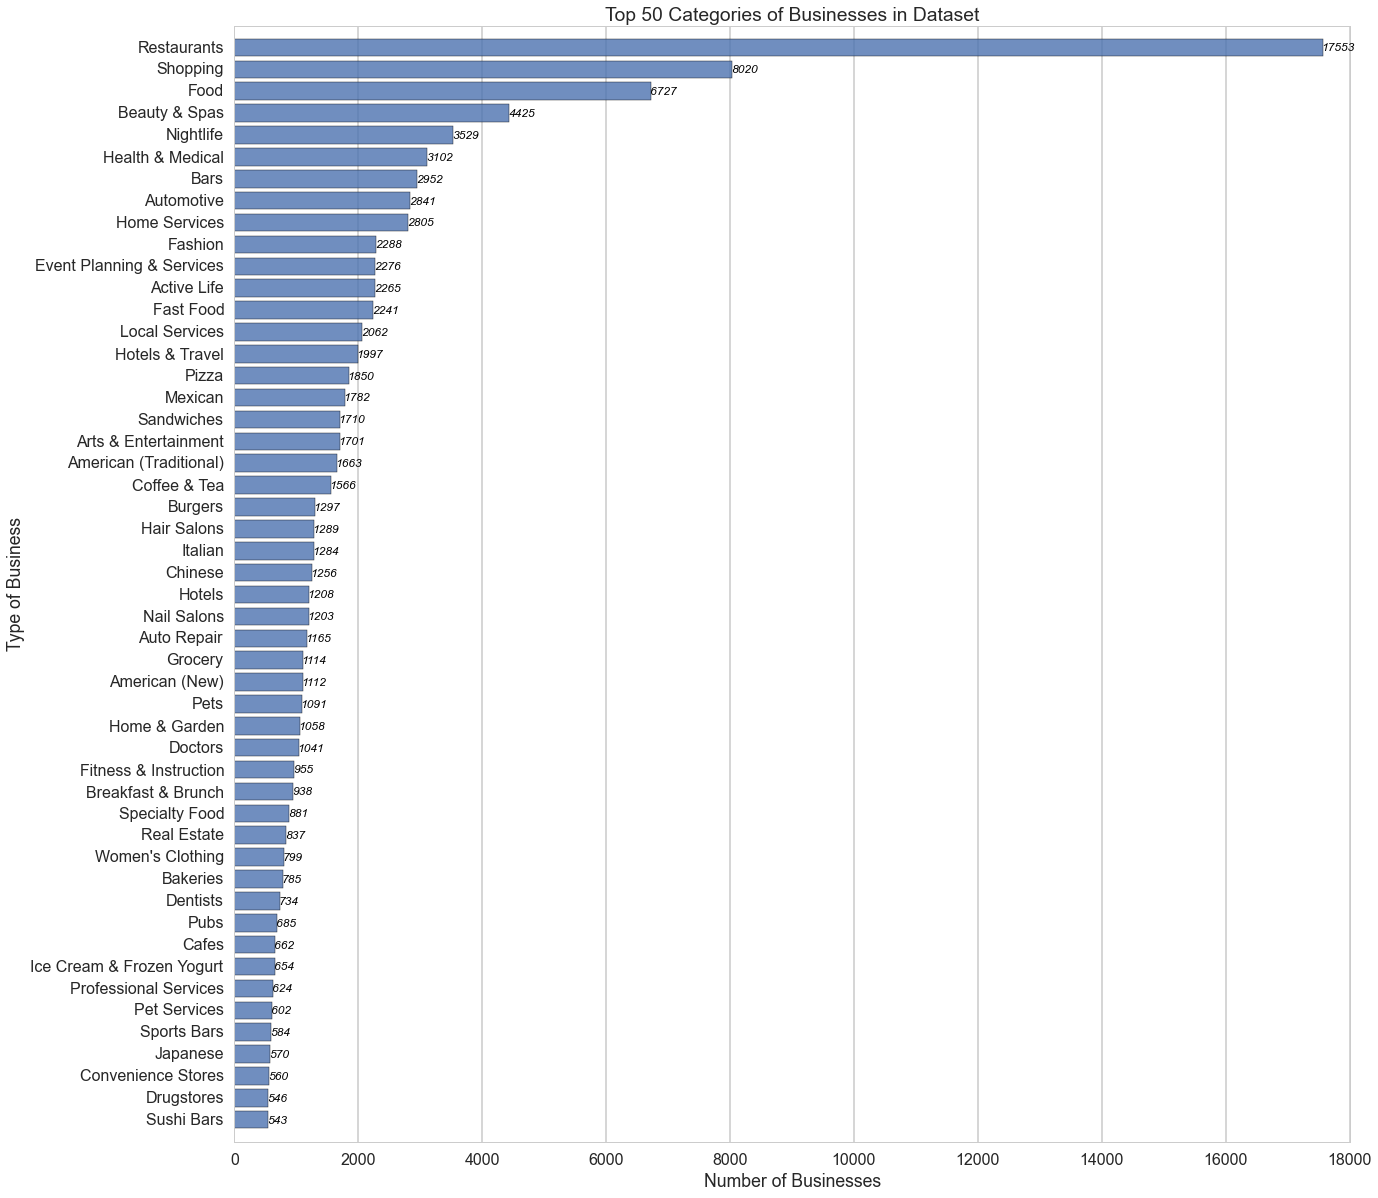

In [12]:
# Get the top categories
top_num = 50
top = sorted(ccounts.items(), key=lambda x:x[1], reverse = True)[:top_num]
top = sorted(top, key = lambda x:x[1])
Y = np.arange(len(top))
bars = plt.barh(Y, map(lambda x:x[1], top), align = 'center', alpha = 0.8)
plt.yticks(Y, map(lambda x:x[0], top))
plt.ylim(-1, top_num)
plt.xlabel("Number of Businesses")
plt.ylabel("Type of Business")
plt.title("Top " + str(top_num) +  " Categories of Businesses in Dataset")
plt.grid(b=None, axis='y')
plt.gcf().set_size_inches(20, 20)
font = {'color':  'black','size': 12}
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + 0.25, bar.get_width(), fontdict=font, style='italic')
plt.show()

In [13]:
# Choose initial categories to use
cstouse = ['Restaurants',
           'Shopping',
           'Food', 
           'Beauty & Spas',
           'Nightlife',
           'Bars',
           'Health & Medical',
           'Automotive',
           'Home Services',
           'Fashion',
           'Active Life',
           'Event Planning & Services',
           'Hotels & Travel',
           'Arts & Entertainment',
           'Coffee & Tea',
           'Grocery',
           'Pets',
           'Fast Food',
           'Drugstores'
          ]

It looks like food-related businesses dominate the most prevalent categories here! With this in mind, we might see a lot of overlap between these categories. For instance, a restaurant serves food, so it might have both labels. If we go back to our initial data frame, we see that most businesses have several category labels. Let's look at the overlap between the categories and see what we find.

In [14]:
# Get the size of intersections between different categories
from itertools import combinations

intersections = {}
for b1, b2 in combinations(cstouse, 2):
    intersections[(b1, b2)] = len(set.intersection(csets[b1], csets[b2]))

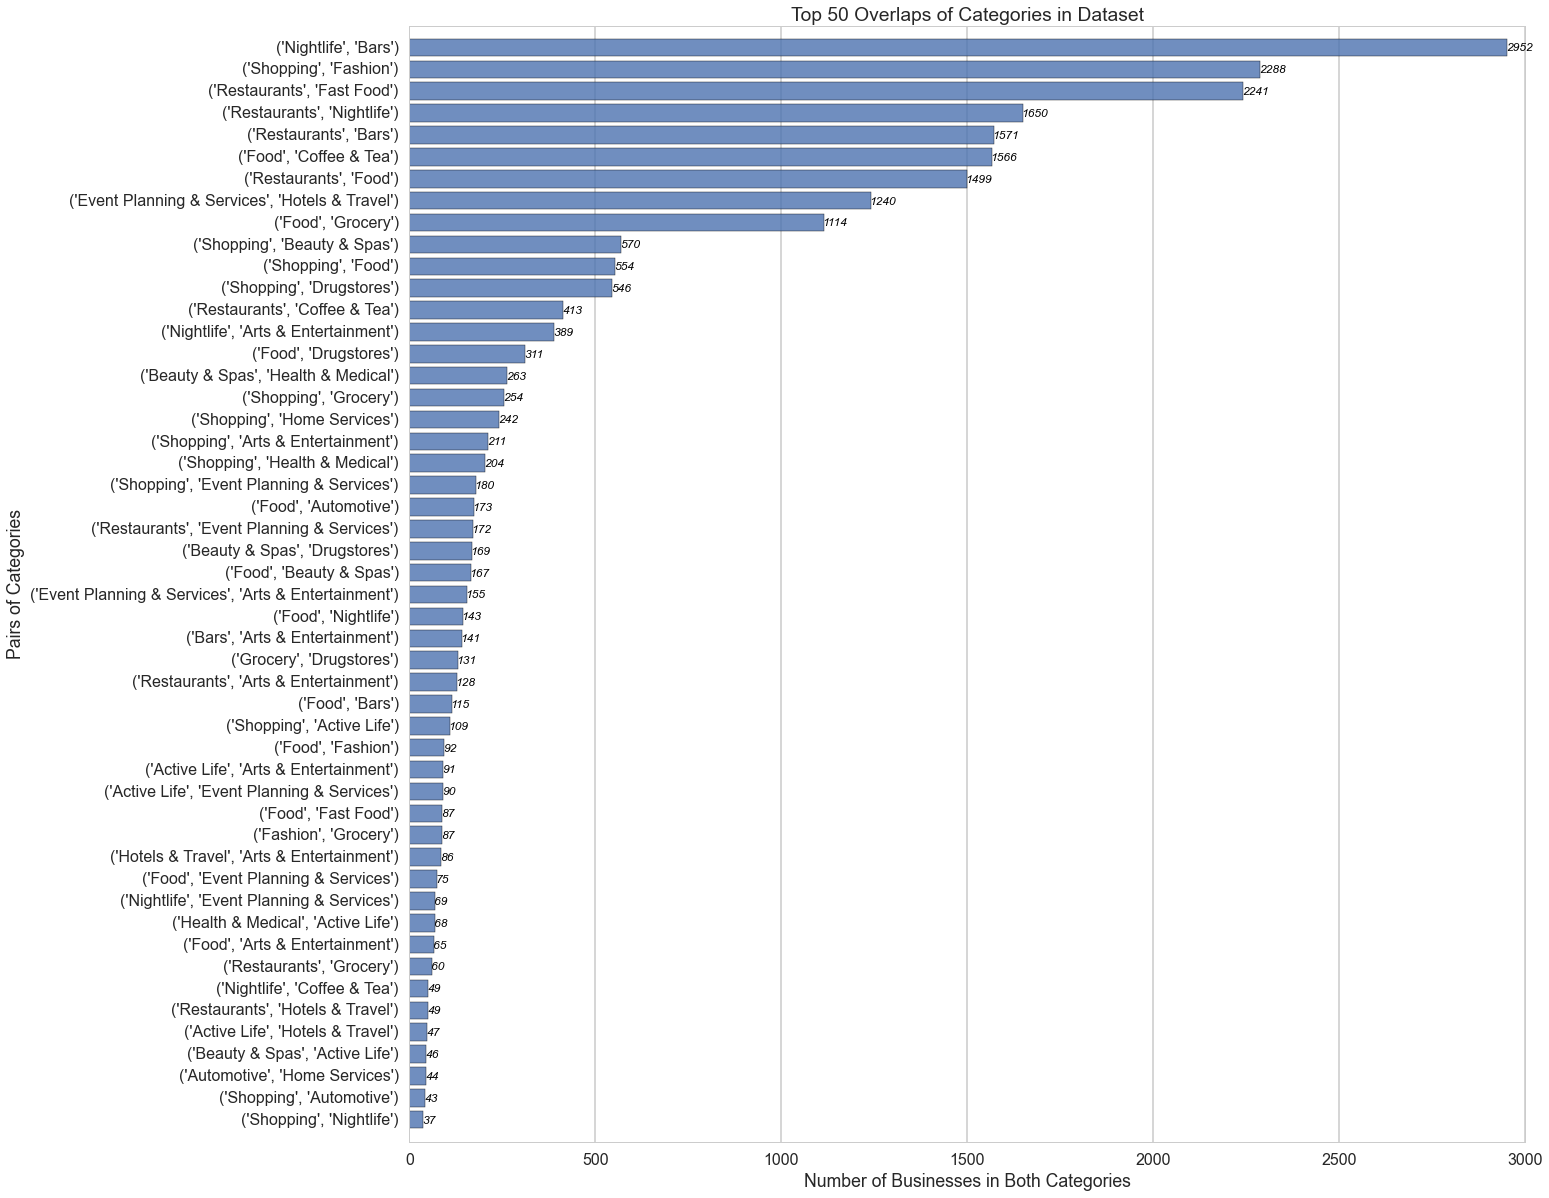

In [15]:
top_is = 50
sorted_is = sorted(intersections.items(), key=lambda x:x[1], reverse = True)[:top_is]
sorted_is.reverse()
Y = np.arange(len(sorted_is))
bars = plt.barh(Y, map(lambda x:x[1], sorted_is), align = 'center', alpha = 0.8)
plt.yticks(Y, map(lambda x:x[0], sorted_is))
plt.ylim(-1, len(sorted_is))
plt.xlabel("Number of Businesses in Both Categories")
plt.ylabel("Pairs of Categories")
plt.title("Top " + str(top_is) +  " Overlaps of Categories in Dataset")
plt.grid(b=None, axis='y')
plt.gcf().set_size_inches(20, 20)
font = {'color':  'black','size': 12}
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + 0.25, bar.get_width(), fontdict=font, style='italic')
plt.show()

Just as expected, there is a big overlap between the food-related categories! There is also a lot of overlap with shopping and other categories. Let's look at these overlaps using Venn Diagrams to get a better idea of which categories are overlapping the most.

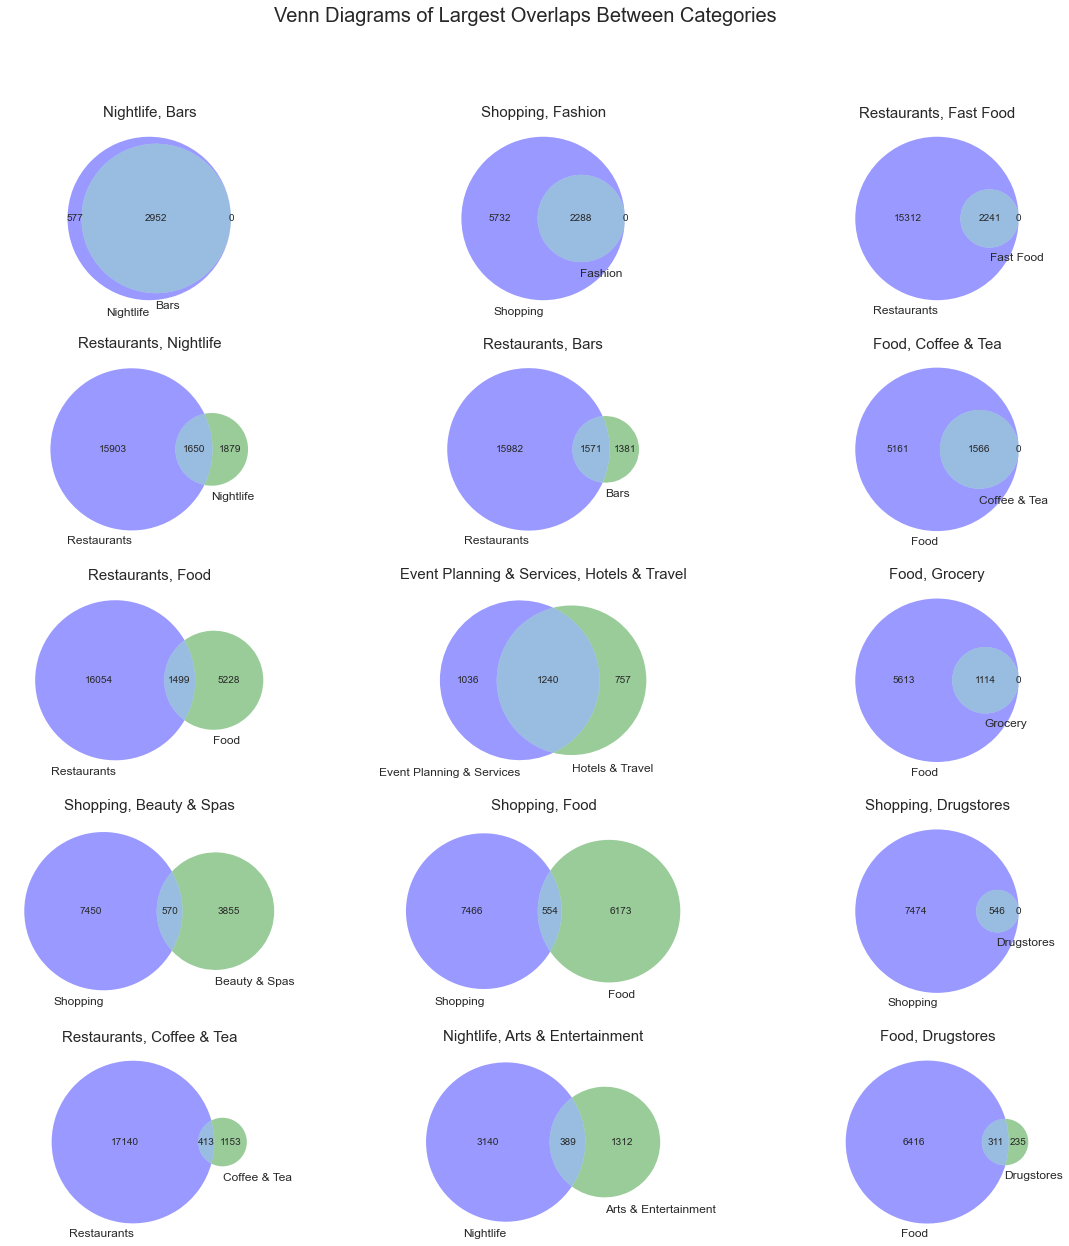

In [16]:
fig, axes = plt.subplots(nrows = 5, ncols=3, figsize=(20,20))
top15=sorted_is[-15:]
top15.reverse()
for ax, pair in zip(axes.ravel(), map(lambda x:x[0], top15)):
    venn2([csets[pair[0]], csets[pair[1]]], set_labels=pair, ax=ax, set_colors=['blue', 'green'])
    ax.set_title(pair[0] + ", " + pair[1], fontsize=15)
fig.suptitle("Venn Diagrams of Largest Overlaps Between Categories", fontsize = 20)
plt.show()

It looks like most of the more specific categories have a lot of overlap with each other. Anything food-related seems to overlap significantly with Restaurants. We are planning on predicting the rating of restaurants based on their neightborhood, so we think it is appropriate to deal with only restaurants in our analysis. Considering how Restaurants covers such a broad range of categories, it should have enough breadth to give us a good analysis and predictive potential.

In [17]:
# make df of only restaurants
restdf = businessdf[["Restaurants" in category for category in businessdf.categories]]
restdf.reset_index(inplace = True, drop = True)
print restdf.shape
restdf.head()

(17553, 16)


,attributes,business_id,categories,city,full_address,hours,latitude,longitude,name,neighborhoods,open,review_count,stars,state,type,metro
0,"{u'Alcohol': u'full_bar', u'Noise Level': u'av...",mVHrayjG3uZ_RLHkLj-AMg,"[Bars, American (New), Nightlife, Lounges, Res...",Braddock,"414 Hawkins Ave\nBraddock, PA 15104","{u'Tuesday': {u'close': u'19:00', u'open': u'1...",40.408735,-79.866351,Emil's Lounge,[],True,11,4.5,PA,business,Pittsburgh
1,"{u'Alcohol': u'full_bar', u'Noise Level': u'lo...",KayYbHCt-RkbGcPdGOThNg,"[Bars, American (Traditional), Nightlife, Rest...",Carnegie,"141 Hawthorne St\nGreentree\nCarnegie, PA 15106",{},40.415517,-80.067534,Alexion's Bar & Grill,[Greentree],True,15,4.0,PA,business,Pittsburgh
2,"{u'Take-out': True, u'Drive-Thru': False, u'Ou...",wJr6kSA5dchdgOdwH6dZ2w,"[Burgers, Breakfast & Brunch, American (Tradit...",Carnegie,"2100 Washington Pike\nCarnegie, PA 15106","{u'Monday': {u'close': u'02:00', u'open': u'08...",40.387732,-80.092874,Kings Family Restaurant,[],True,8,3.5,PA,business,Pittsburgh
3,"{u'Alcohol': u'full_bar', u'Noise Level': u'av...",fNGIbpazjTRdXgwRY_NIXA,"[Bars, American (Traditional), Nightlife, Loun...",Carnegie,"1201 Washington Ave\nCarnegie, PA 15106",{},40.396469,-80.084942,Rocky's Lounge,[],True,5,4.0,PA,business,Pittsburgh
4,"{u'Alcohol': u'none', u'Noise Level': u'averag...",b9WZJp5L1RZr4F1nxclOoQ,"[Breakfast & Brunch, Restaurants]",Carnegie,"1073 Washington Ave\nCarnegie, PA 15106","{u'Monday': {u'close': u'14:30', u'open': u'06...",40.396744,-80.084800,Gab & Eat,[],True,38,4.5,PA,business,Pittsburgh


## Exploratory Data Analysis##

Using such a large data from such a diverse range of cities will make our analysis very difficult. What makes a neighborhood give us good ratings in Las Vegas will be very different from Edinburgh. Since we want to be able to predict the rating of restaurant given its neighborhood, it seems silly to predict rating of restauring in Phoenix based on what neighborhood features make a restaurant in Scotland popular. For this reason, we will focus only on the Arizona businesses, as they had the most data points.

Let's look at the general trends for ratings and prices for restaurants in Phoenix.



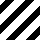
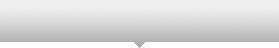
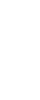
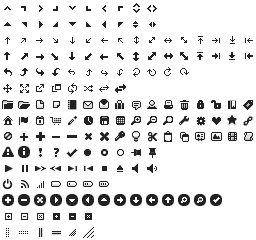
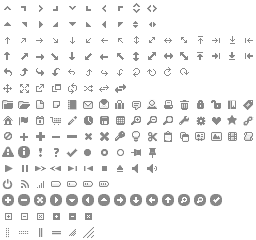
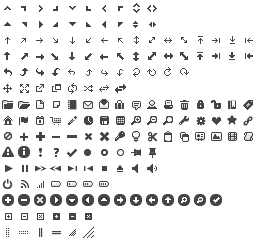
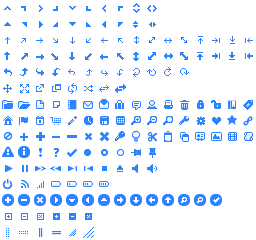
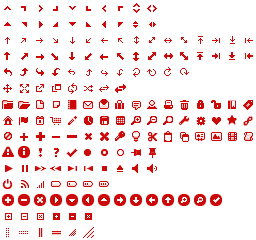
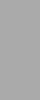
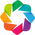
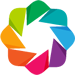
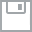
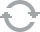
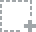
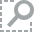
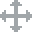
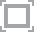
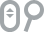

In [18]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.palettes import RdYlBu9 as palette
output_notebook()

### Star Ratings ###

In [19]:
AZdf = restdf[restdf.metro == 'Phoenix'].reindex()
AZdf.index = range(0, AZdf.shape[0])

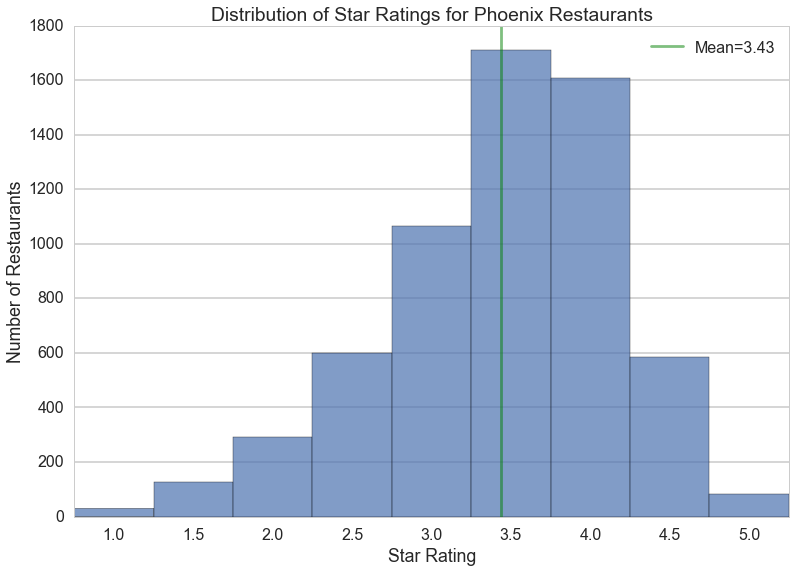

In [20]:
plt.hist(AZdf['stars'], bins = np.arange(1.0,6.0,0.5), alpha = 0.7)
plt.xticks(np.arange(1.25, 5.75, 0.5), np.arange(1.0,5.5, 0.5))
plt.axvline(AZdf.stars.mean() + 0.25, color='g', label='Mean='+str(AZdf.stars.mean())[:4], alpha = 0.5)
plt.legend()
plt.grid(axis = 'x')
plt.xlabel("Star Rating")
plt.ylabel("Number of Restaurants")
plt.title("Distribution of Star Ratings for Phoenix Restaurants")
plt.show()

### Prices ###

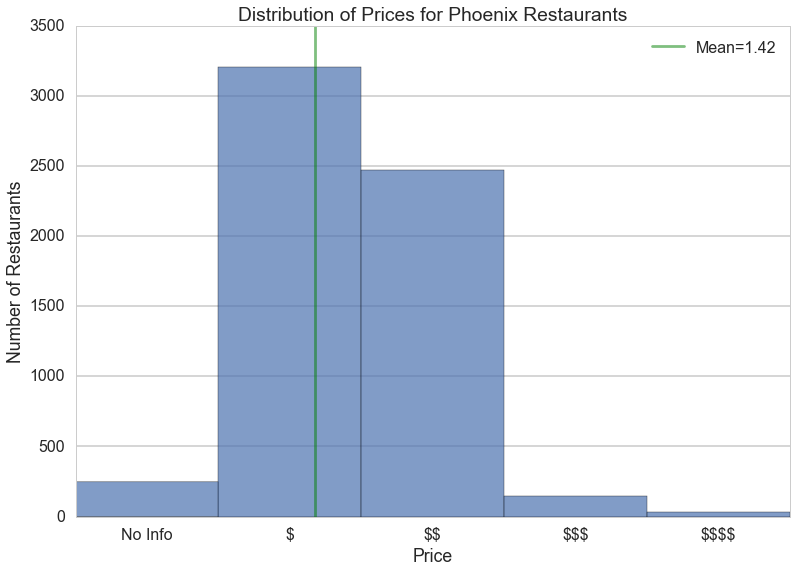

In [21]:
# plot histogram of prices
def price(d):
    if "Price Range" in d.keys():
        return d["Price Range"]
    else:
        return 0
    
prices = map(price, AZdf.attributes)
plt.hist(prices, bins = np.arange(0.0,6.0,1.0), alpha = 0.7)
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5], ['No Info', '\$', '\$\$', '\$\$\$', '\$\$\$\$'])
plt.axvline(np.mean(prices) + 0.25, color='g', label='Mean='+str(np.mean(prices))[:4], alpha = 0.5)
plt.legend()
plt.grid(axis = 'x')
plt.title("Distribution of Prices for Phoenix Restaurants")
plt.xlabel("Price")
plt.ylabel("Number of Restaurants")
plt.show()

### Opening and Closing Times ###

Now, let's define a function `ave_hours` which takes a dictionary of a  restaurant's weekly hours (this of the form of the current `hours` column in the dataset), and returns the average opening & closing times of the restaurant. We will use this function to investigate open and closing times of restaurants below and also use it later in our models.

In [22]:
def ave_hours(hours_dict):
    # initilialize lists to hold open & close times
    open_list = []
    close_list = []
    # for each day in dictionary
    for day in hours_dict:
        # convert time to float and add to list
        open_list.append(float(hours_dict[day]['open'][:2]) + float(hours_dict[day]['open'][3:])/60.)
        # convert closing time to float
        close = float(hours_dict[day]['close'][:2]) + float(hours_dict[day]['close'][3:])/60.
        # if it closes past midnight, add 24 to close time to simulate time passing
        if close < 9:
            close = 24 + close
        close_list.append(close)
    # return means of each list
    return(np.mean(open_list), np.mean(close_list))

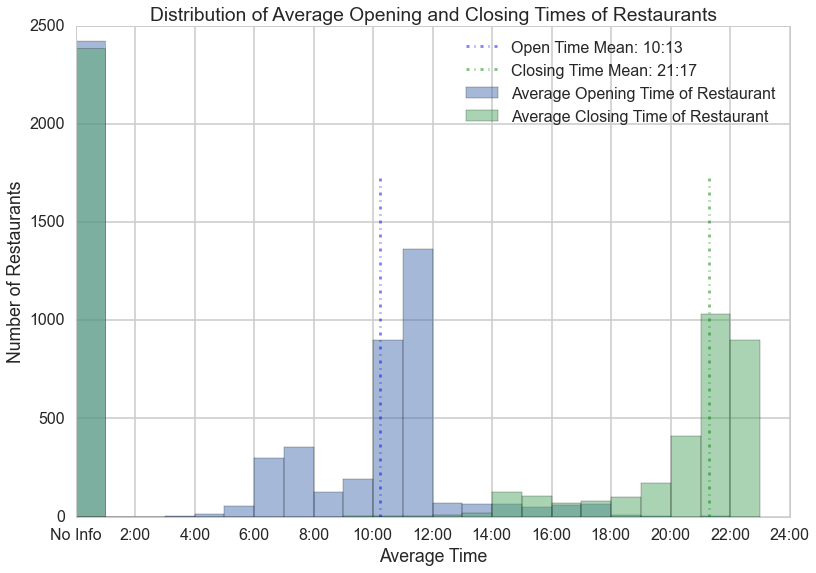

In [23]:
def open_time(hours_dict):
    if hours_dict == {}:
        return 0
    else:
        return ave_hours(hours_dict)[0]

def close_time(hours_dict):
    if hours_dict == {}:
        return 0
    else:
        return ave_hours(hours_dict)[1]

def to_time(i):
    return str(int(i)) + ":" + str(int(((i - int(i)) * 60)))
    
hours = ['No Info'] + map(lambda i: str(i) + ":00", range(2, 26, 2))
open_times = np.array(map(open_time, AZdf.hours))
close_times = np.array(map(close_time, AZdf.hours))
plt.hist(open_times, bins = range(0,24,1), alpha = 0.5, label="Average Opening Time of Restaurant")
plt.hist(close_times, bins = range(0,24,1), alpha = 0.5, label="Average Closing Time of Restaurant")
av_open = np.mean(open_times[open_times != 0])
av_close = np.mean(close_times[close_times != 0])
plt.axvline(av_open, color='b', ymax = 0.7, ls = '-.',
            label='Open Time Mean: '+ to_time(av_open), alpha = 0.5)
plt.axvline(av_close, color='g', ymax = 0.7, ls = '-.', 
            label='Closing Time Mean: '+ to_time(av_close), alpha = 0.5)
plt.xticks(range(0,26, 2), hours)
plt.xlim(0, 24)
plt.xlabel("Average Time")
plt.ylabel("Number of Restaurants")
plt.legend()
plt.title("Distribution of Average Opening and Closing Times of Restaurants")
plt.show()

### Interactive Plot Using Boquet ###

In [24]:
def color(x):
    return palette[(2*x - 2)]

In [25]:
AZdf['color'] = AZdf.stars.map(lambda x: color(int(x)))
AZdf.head()

,attributes,business_id,categories,city,full_address,hours,latitude,longitude,name,neighborhoods,open,review_count,stars,state,type,metro,color
0,"{u'Take-out': True, u'Accepts Credit Cards': T...",x5Mv61CnZLohZWxfCVCPTQ,"[Sandwiches, Pizza, Chicken Wings, Restaurants]",Phoenix,"2819 N Central Ave\nPhoenix, AZ 85004",{},33.479542,-112.073418,Domino's Pizza,[],True,11,3.0,AZ,business,Phoenix,#ffffbf
1,"{u'Take-out': True, u'Noise Level': u'quiet', ...",2ZnCITVa0abGce4gZ6RhIw,"[American (New), Sandwiches, Restaurants]",Phoenix,"1850 N Central Ave\nPhoenix, AZ 85004",{},33.468988,-112.074315,Viad Tower Restaurants,[],True,5,3.5,AZ,business,Phoenix,#ffffbf
2,"{u'Alcohol': u'full_bar', u'Price Range': 1, u...",EmzaQR5hQlF0WIl24NxAZA,"[American (New), Nightlife, Dance Clubs, Resta...",Phoenix,"132 E Washington St\nPhoenix, AZ 85004","{u'Sunday': {u'close': u'02:00', u'open': u'21...",33.448399,-112.071702,Sky Lounge,[],True,23,2.5,AZ,business,Phoenix,#abd9e9
3,"{u'Take-out': True, u'Accepts Credit Cards': T...",KPoTixdjoJxSqRSEApSAGg,"[Thai, Restaurants]",Phoenix,"2631 N Central Ave\nPhoenix, AZ 85004","{u'Monday': {u'close': u'21:00', u'open': u'11...",33.477934,-112.073524,Wild Thaiger,[],True,322,4.0,AZ,business,Phoenix,#fdae61
4,"{u'Alcohol': u'full_bar', u'Open 24 Hours': Fa...",e5kc0CQ4R-PCCDgb274gSg,"[Mexican, Tex-Mex, Restaurants]",Phoenix,"455 N 3rd St\nSte 114\nPhoenix, AZ 85004","{u'Monday': {u'close': u'21:00', u'open': u'11...",33.452603,-112.069119,Canyon Cafe,[],True,191,3.5,AZ,business,Phoenix,#ffffbf


In [26]:
p = figure(title = 'AZ Star Ratings')
p.circle(AZdf.longitude, AZdf.latitude, color = AZdf.color)
show(p)

## Finding Neighbors ##

Finally, let's find the neighbors for each restaurant. We will use a function, knearest, where we find the the closest restaurants to each restaurant (closest using distance). We will use these neighbors from in our models.

In [27]:
from sklearn.neighbors import BallTree

"""
Function
--------
make_tree

Parameters
----------
df: instance of Data Frame class
    Data Frame of businesses to make tree out of
    
Returns
--------
A tuple of:
    A Ball Tree of businesses organized by their geographical distance
    A dictionary of latitudes and longitudes with keys being business ids
"""

def make_tree(df):
    # convert latitude and longitude to radians
    to_r = 0.0174533
    lat = df.latitude.map(lambda l : to_r * l)
    lon = df.longitude.map(lambda l : to_r * l)
    # dictionary with keys business id's and values (latitude, longitude)
    latlng = dict(zip(df.business_id, zip(lat, lon)))
    # use haversine distance for distance on sphere
    return BallTree(latlng.values(), metric = 'haversine'), latlng

In [28]:
"""
Function
--------
get_nearest

Parameters
----------
b_id: string
    The id of the business we want to get the neighbors of       
tree: instance of the BallTree class
    The tree we want to use to find neighbors    
latlng: dict
    a dictionary with keys business ids and values tuples of
    latitudes and longitudes (as is returned by make_tree)
bids: numpy array
    an array of business ids indexed in the sae way that the keys
    of latlng are indexed found using bids = np.array(latlng.keys())
k: int
    The number of neighbors we want to find
r: int
    The radius in miles in which we want to find neighbors 
    (either use k or r not both)
    
Returns
--------
A dict constiting of the items:
    neighbors: a list 
        of the business id's of the k nearest neighbors (excluding the business itself)       
    dist: a list 
        of the distances of each of the restaurants in miles, given in the
        same order as the list of business ids
"""

def get_nearest(b_id, tree, latlng, bids, k, r=None):
    # radius of the earth in miles
    R = 3959.0
    if k:
        # get k closest neighbors
        d, ind = tree.query(latlng[b_id], k = k + 1)
    if r:
        r = float(r)/R
        ind, d = tree.query_radius(latlng[b_id], r=r, return_distance = True)
    # scale the distance by earth's radius to get miles
    dist = d[0] * R
    ind = ind[0]
    neighbors = {}
    # exclude the restaurant we are querying
    ids = bids[ind]
    i = np.where(ids == b_id)
    neighbors["dist"] = np.delete(dist, i)
    neighbors["neighbors"] = np.delete(ids, i)
    return neighbors

In [61]:
tree, latlng = make_tree(restdf)
bids = np.array(latlng.keys())
# define function knearest that takes in business id and k-value and returns k nearest restaurants to be used below
knearest = lambda b_id, k: get_nearest(b_id, tree, latlng, bids, k)

In [30]:
"""
Function
--------
nearest_dict

Parameters
----------
df_in: instance of the DataFrame class
    The Data Frame of restaurants we want to find neighbors of
df_neighbors: instance of the DataFrame class
    The Data Frame consisting of potential neighbors 
k: int
    The number of neighbors to find for each business
    
Returns
--------
A dict with
    keys: business_ids
    values: lists of tuples (business_id, distance) of the k nearest neighbors
    to a business
"""

def nearest_dict(df_input, df_neighbors, k = None, r = None):
    if (k and r):
        raise "Enter either k or r not both!"
    if (not k and not r):
        raise "Must enter a value for one of k or r!"
    tree, latlng = make_tree(df_neighbors)
    nearest = {}
    bids = np.array(latlng.keys())
    if k:
        for bid in df_input.business_id:
            nearest[bid] = get_nearest(bid, tree, latlng, bids, k)
    if r:
        for bid in df_input.business_id:
            nearest[bid] = get_nearest(bid, tree, latlng, bids, None, r)
    return nearest

In [31]:
%%time
"""
Example usage:
"""
# To find everything within 1 mile radius
mile_nearest = nearest_dict(restdf, businessdf, r = 1.0)

# To find 5 nearest businesses
five_nearest = nearest_dict(restdf, businessdf, k = 5)

CPU times: user 10.4 s, sys: 630 ms, total: 11.1 s
Wall time: 11.6 s


In [32]:
bindexed = businessdf.set_index("business_id", drop = False)

"""
Function
--------
make_neighborsdf

Use
--------
Most useful for testing whether nearest neighbors worked.

Parameters
----------
b_id: string
    The id of the business we want to find neighbors of
nearest: dict
    The dictionary of neighbors to a business (as would be returned by nearest_dict)
bdf: instance of the Data Frame class
   The dataframe of businesses from which the neighbors come
    
Returns
--------
A Data Frame
    with the restaurant as the first row and the k nearest businesses to it, including a column
    with their distance to the restaurant
"""

def make_neighborsdf(b_id, nearest):
    neighbors = bindexed.loc[[b_id] + nearest[b_id]["neighbors"].tolist()]
    neighbors["distance"] = [0] + nearest[b_id]["dist"].tolist()
    return neighbors

In [34]:
make_neighborsdf(restdf.business_id[0], mile_nearest).head(5)

,attributes,business_id,categories,city,full_address,hours,latitude,longitude,name,neighborhoods,open,review_count,stars,state,type,metro,distance
business_id,,,,,,,,,,,,,,,,,
mVHrayjG3uZ_RLHkLj-AMg,"{u'Alcohol': u'full_bar', u'Noise Level': u'av...",mVHrayjG3uZ_RLHkLj-AMg,"[Bars, American (New), Nightlife, Lounges, Res...",Braddock,"414 Hawkins Ave\nBraddock, PA 15104","{u'Tuesday': {u'close': u'19:00', u'open': u'1...",40.408735,-79.866351,Emil's Lounge,[],True,11,4.5,PA,business,Pittsburgh,0.000000
IyX5dihB9_LNpTFpn8JsUQ,{},IyX5dihB9_LNpTFpn8JsUQ,"[Banks & Credit Unions, Financial Services]",Rankin,"249 5th Ave\nSte 30\nRankin, PA 15104",{},40.413898,-79.879827,PNC Corporate Headquarters,[],True,3,1.0,PA,business,Pittsburgh,0.793712
nciJNwbEFuz30IDBvv5pUg,{},nciJNwbEFuz30IDBvv5pUg,"[Landmarks & Historical Buildings, Public Serv...",Rankin,"N Braddocksfield Ave\nRankin, PA 15104",{},40.408806,-79.878160,Rivers of Steel National Heritage Area,[],True,8,4.5,PA,business,Pittsburgh,0.621360
keC-Z_YMwd569_NnZ4koaw,"{u'Price Range': 2, u'Accepts Credit Cards': T...",keC-Z_YMwd569_NnZ4koaw,"[Food, Breweries]",Braddock,"512 Braddock Ave\nBraddock, PA 15104","{u'Friday': {u'close': u'23:00', u'open': u'17...",40.404099,-79.870272,The Brew Gentlemen Beer Company,[],True,22,4.5,PA,business,Pittsburgh,0.381030
IS9ZqBV6R0olC_OYv-vGjQ,"{u'Take-out': True, u'Price Range': 2, u'Outdo...",IS9ZqBV6R0olC_OYv-vGjQ,"[Chinese, Restaurants]",Pittsburgh,"268 Yost Blvd\nPittsburgh, PA 15221",{},40.414032,-79.850650,Zhen Choo Chinese Restaurant,[],True,4,4.0,PA,business,Pittsburgh,0.903508


## Building Models ##

### Baseline Model 1 ###

To start off in making our predictions, we can try just taking the average rating of the nearby restaurants around the restaurant of interest. This measure may not be useful, but it will be good to start off with before getting into more complex models.  In this case, we'll make the assumption that a neighborhood consists of a restaurant's 10 (physically) closest restaurants (though as we'll see later, the number of closest neighbors can be optimized, much like a hyperparameter). To do this we make a dictionary of the 10 closest neighbors for each restaurant:

In [42]:
%%time
# dictionary that has average of all neighbors for given restaurant ID
nearest = nearest_dict(restdf, restdf, k=10)
nearest_av = {}
k = 10
for bid in nearest:
    nearest_av[bid] = bindexed.stars.loc[nearest[bid]["neighbors"]].mean()

CPU times: user 10.8 s, sys: 235 ms, total: 11.1 s
Wall time: 11.2 s


Our measure can then be easily calculated:

In [37]:
# baseline (average of neighbors)
def baseline1(bid):
    return nearest_av[bid]

We then store these predictions in a list for later testing:

In [38]:
# make the predictions
pred_bs1 = [baseline1(b) for b in restdf.business_id]

But we can improve upon this. Within the neighborhood, it may be that neighbors closer to the restaurant of interest may have more of an effect on its rating than others. So when we take the average of the neighborhood, we may also want to weight the star ratings of the other restaurants by distance from the restaurant we are trying to predict. Therefore, we calculate a weighted baseline, the weight

$$w_i = 0.5^{distance} \log(\text{review count})$$

assuming that a restaurant a mile away is half as valuable as a restaurant located exactly where the restaurant we are predicting on is and weighting by the review count (which we log since it is severely right skewed).

In [39]:
# weighted baseline (weighted average of neighbors by distance)
def weighted_baseline(bid):
    ns = nearest[bid]["neighbors"]
    weights = 0.5**(nearest[bid]["dist"]) * np.log(bindexed.review_count.loc[ns])
    stars = bindexed.stars.loc[ns]
    return sum(stars*weights)/sum(weights)

In [41]:
%%time
# make the weighted predictions
pred_bsw1 = [weighted_baseline(b) for b in restdf.business_id]

CPU times: user 20.5 s, sys: 335 ms, total: 20.8 s
Wall time: 21.6 s


Next, in order to be able to measure the strength and validity of our predictions, we define a couple functions, both of which are taken straight out of Homework 4. `get_rmse` calculates the root mean squared error between an array of predictions and actual values, while `compare_results` plots the actual and predicted values (along with a line of slope=1) and also reports the RMSE.

In [43]:
# get the RMS error (taken from Pset 4)
def get_rmse(s, s_predict):
    diff = s - s_predict
    return np.sqrt(np.dot(diff,diff)/diff.shape[0])

In [44]:
# graph the actual vs predicted (taken from Pset 4)
def compare_results(stars_actual, stars_predicted, ylow=1, yhigh=6, model="", predicteds=False, onsame=False, axis=False):
    """
    plot predicted results against actual results. Takes 2 arguments: a
    numpy array of actual ratings and a numpy array of predicted ratings
    scatterplots the predictions, a unit slope line, line segments joining the mean,
    and a filled in area of the standard deviations."
    """
    if onsame:
        ax=onsame
    elif axis:
        ax=axis
    else:
        fig=plt.figure()
        ax=plt.gca()
    df=pd.DataFrame(dict(actual=stars_actual, predicted=stars_predicted))
    xp=[]
    yp=[]
    for k,v in df.groupby('actual'):
        xp.append(k)
        yp.append(v.predicted.mean())        
    
    cl, = ax.plot(xp,yp, 's-', label="means for %s" % model)
    c=cl.get_color()

    sig=df.groupby('actual').predicted.std().values
    ax.fill_between(xp, yp - sig, yp + sig, 
                 color=c, alpha=0.2)
    if predicteds:
        ax.plot(df.actual, df.predicted, '.', color=c, alpha=0.1, label="predicted for %s" % model)

    if not onsame:
        ax.plot([1,5],[1,5], 'k', label="slope 1")
        ax.set_xlabel("actual")
        ax.set_ylabel("predicted")
        ax.set_ylim([ylow,yhigh])
        ax.set_xlim([0.9, 5.1])
    ax.legend(frameon=False, loc="upper left")
    rmse=get_rmse(stars_actual, stars_predicted)
    print "RMSE for %s" % model, rmse
    return ax,rmse

Now we can plot our results to compare both models (unweighted & weighted) and see how they performed:

RMSE for Baseline #1 0.731335190943
RMSE for Weighted Baseline #1 0.729518756943


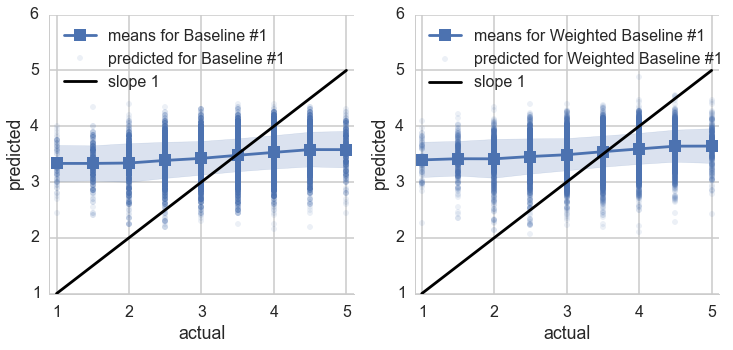

In [108]:
import warnings
# ignore the warning coming from compare_results
warnings.filterwarnings('ignore')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
compare_results(restdf.stars, pred_bs1, model = "Baseline #1", predicteds = True, axis = axes[0])
compare_results(restdf.stars, pred_bsw1, model = "Weighted Baseline #1", predicteds = True, axis = axes[1])
sns.despine()

Our weighted model performs slightly better than the non-weighted one (as can be seen from RMSE), but not by much. Additionally, overall the predictions seem to be following the right trend (positive slope) but there is still much to be improved. It may be helpful to add a couple more measurements into our model to see if we can improve this baseline model.

### Baseline Model 2 and Local Recommender ###

Perhaps our previous model didn't take enough measures into account. Maybe we could we can calculate a baseline model that's a little more nuanced, based upon the mean of all restaurants, as well as the mean of the neighbors of that specific restaurant:

$$ \hat Y^{baseline}_{r} = \bar Y + (\bar Y_{nr} - \bar Y_n) $$

Where $\bar Y$ is the mean of all restaurants, $\bar Y_{nr}$ is the average rating for the restaurant's neighbors, and $\bar Y_n$ is the average rating for all neighborhoods. This allows us to gain a general average for how all restaurants are rated, and then build off of this by calculating how the neighborhood is rated compared to other neighborhoods (in other words, we adjust for the neighborhood's "bias"). We then define a function to calculate our baseline measure:

In [46]:
def baseline2(bid):
    ybar = restdf.stars.mean()
    ynr = nearest_av[bid]
    yn = np.mean(nearest_av.values())
    return ybar + (ynr - yn)

And then make a list of all predictions according to this measure:

In [48]:
%%time
pred_bs2 = [baseline2(b) for b in restdf.business_id]

CPU times: user 15.6 s, sys: 223 ms, total: 15.8 s
Wall time: 16.3 s


But wait--we can still improve this model by adding weights, just like we did last time! Using the same weighting scheme as before, we can now revise this model to develop a local recommender:

$$ \hat{Y_{r}} = \bar Y\, + \,\frac{\sum\limits_{i \in n} w_{ni} ( Y_{ni} - \bar Y_{n} )}{\sum\limits_{i \in n} w_{ni}} $$

Where $w_{ni}$ is the weight and $Y_{ni}$ is the rating for the $i^{th}$ neighbor. We make another function for this model:

In [49]:
def weighted_baseline2(bid):
    ns = nearest[bid]["neighbors"]
    ybar = restdf.stars.mean()
    weights = 0.5**(nearest[bid]["dist"]) * np.log(bindexed.review_count.loc[ns])
    neigh_rats = bindexed.stars.loc[ns]
    neighs_ave = np.mean(nearest_av.values())
    return ybar + sum(weights*(neigh_rats-neighs_ave))/sum(weights)

In [50]:
%%time
pred_bsw2 = [weighted_baseline2(b) for b in restdf.business_id]

CPU times: user 35 s, sys: 267 ms, total: 35.3 s
Wall time: 35.4 s


We again plot our results to compare the performance of the two models:

RMSE for Baseline #2 0.731187483122
RMSE for Local Recommender 0.730676420421


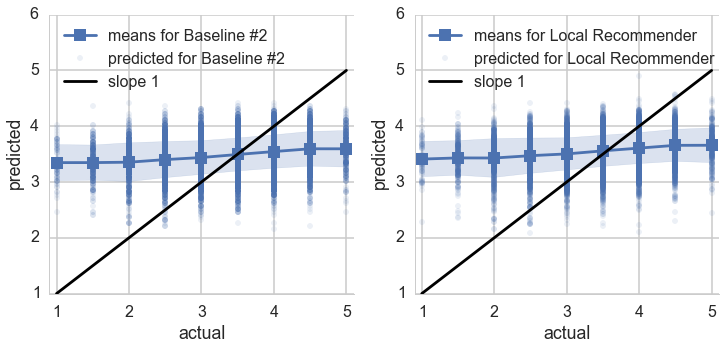

In [51]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
compare_results(restdf.stars, pred_bs2, model = "Baseline #2", predicteds = True, axis = axes[0])
compare_results(restdf.stars, pred_bsw2, model = "Local Recommender", predicteds = True, axis = axes[1])
sns.despine()

Our weighted model (aka local recommender) was slightly better once again, but neither improved upon the first weighted model built earlier in terms of RMSE. Perhaps it's time we've learned out lesson and move on to something where we can fit and train our data.

### Ridge Regression - Using Neighbor Indicators ###

Now instead of using the ratings of the neighbors, we can use a Ridge Regression model to possibly predict how each restaurant acts as a neighbor and what influence it may have on a restaurant of interest in the neighborhood. Since we plan on training our data, we'll also want to split it into training and testing sets. We first do this by creating a mask:

In [52]:
from sklearn.linear_model import Ridge
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(len(AZdf)), train_size=0.7, random_state=123)
mask=np.ones(len(AZdf), dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

And then by splitting using this mask:

In [53]:
rest_train = AZdf[mask].reset_index(drop=True)
rest_test = AZdf[~mask].reset_index(drop=True)

However, since we also have two "hyperparameters" that we'll want to optimize (the alpha argument of the ridge regression and the k number of neighbors), we'll want to split up our current test set into validation and test sets:

In [54]:
itrain, itest = train_test_split(xrange(len(rest_test)), train_size=.55, random_state=123)
mask=np.ones(len(rest_test), dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

rest_val = rest_test[mask].reset_index(drop=True)
rest_test = rest_test[~mask].reset_index(drop=True)

Awesome! Now we're set to start putting together the matrix that can be used to carry out the ridge regression. We start by creating a dictionary `idmap` that enumerates each `business_id` and therefore makes a database of the indices of each restaurant (we do this so that we can know the column index for each specific restaurant in our matrix).

In [55]:
# create ID map to reference business in matrix
rest_ids=restdf.business_id.unique()#unique-restaurant-ids
idmap={v:k for k,v in enumerate(rest_ids)}

Now we write a function `form_matrix` which takes a dataframe and integer `k` (determines the number of nearest neighbors) to  construct a matrix that has shape R x N, where R is the number of reviews/restaurants in the given dataframe and N the number of restaurants in the entire dataset. It then goes through each row (which represents a specific restaurant in the given dataframe) and marks a 1 at a given neighbor's index (we find the index from the `idmap` we just made). In other words, it sets up a regression of a bunch of indicator variables, each indicator being a possible neighbor (those that are the neighbors have a value of 1, while those that are not have a value of 0).

#### Forming a Matrix ####

In [56]:
def form_matrix(indf, k):
    # get actual ratings from stars column
    ratings = indf.stars
    # set up matrix of all 0s, with col# = restaurant# and row# = indf row#
    designmatrix = np.matrix([list(np.repeat(0,len(restdf)))]*indf.shape[0])
    
    # go through each column of indf and matrix
    for i in range(0,indf.shape[0]):
        neighs = knearest(indf.business_id[i], k)
        
        for neigh in neighs["neighbors"]:
            # using our maps, find location for corresponding user & item in row
            neigh_loc = idmap[neigh]

            # set values of this user & item to 1 in design matrix
            designmatrix[i,neigh_loc] = 1
        
    return (designmatrix, ratings)

Cool! Now we're able to carry out the regression. We run a cross-validation loop through each combination of several values of `alpha` and `k`. In each loop, we get the matrix for our training set, and fit the regression on it (along with our outcome variable `stars`). Then we predict on the matrix of the validation set. Finally, we store each model and RMSE in their own dictionaries for later use.

In [62]:
%%time
alphas = [0.01, 0.1, 10, 100, 1000]
ks = [5, 10, 15, 20, 25]
rdict = {}
vdict = {}

# iterate through alpha values
for a in alphas:
    for k in ks:
        designm, ratings = form_matrix(rest_train, k)
        valdm, valrats = form_matrix(rest_val, k)
        # fit model on training, predict on validation
        model = Ridge(alpha=a).fit(designm, ratings)
        valpred = model.predict(valdm)
        # store model and RMSE in respective dictionaries
        rdict[(a,k)] = model
        vdict[(a,k)] = get_rmse(valrats, valpred)

CPU times: user 13min 11s, sys: 35.4 s, total: 13min 46s
Wall time: 7min 26s


To find the best model (aka model with hyperparameters that give the smallest RMSE), we can simply look to the dictionaries we stored our results in. We print the best hyperparameters as (`alpha`, `k`) and store the best model in the variable `regr`.

In [63]:
minerror=min(vdict, key=vdict.get)
print minerror
regr=rdict[minerror] 
print regr

(100, 10)
Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, solver='auto', tol=0.001)


Now comes the moment of truth to see how our predictions did! Since we have our best-fitted model, we can predict on the matrix of the test set. We'll also want to store our predictions in a dictionary `predictions` under `ridge1` so that these can be used for later in ensembling.

In [64]:
testdm, testrats = form_matrix(rest_test, minerror[1])
testpred = regr.predict(testdm)
valdm, valrats = form_matrix(rest_val, minerror[1])
valpred = regr.predict(valdm)

In [65]:
predictions={}
predictions_valid = {}
predictions['ridge1'] = testpred
predictions_valid['ridge1'] = valpred

RMSE for Basic Ridge Regression 0.739713042628


(<matplotlib.axes._subplots.AxesSubplot at 0x130baf990>, 0.73971304262834114)

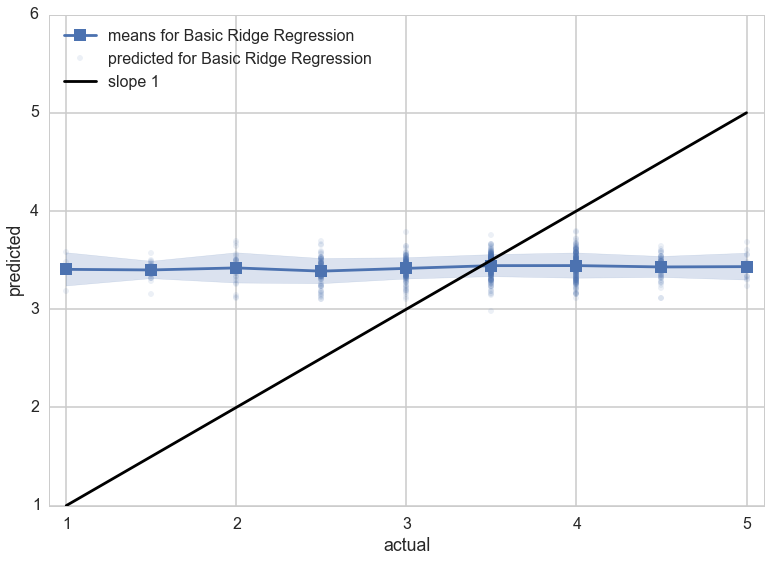

In [66]:
compare_results(testrats, testpred, model = "Basic Ridge Regression", predicteds = True)
plt.show()

Man, our predictions didn't fair well once again. In fact, it looks like they got a bit worse. Our predictions look like a flat line across all ratings. But maybe we've been doing this the wrong way all along--maybe instead of taking individual neighbors or neighborhood ratings into account, we should instead find other measures and attributes of both the restaurant and neighborhood. This brings us to the next step in our analysis!

### Gauging Feature Importance through Random Forest ###

In order take into account various attributes of both the restaurant and its corresponding neighborhood, we'll want to totally switch up the variables, or features, that we'll be using. While the dataset is limited in its current form, we can break up several columns (for example, the `attributes` and `categories` columns have a lot of juicy information) to get more out of our dataset. From the current data we have, we'll want to make several new columns:

* `neigh_av` - the average rating of the neighborhood--we've used this measure before
* `same_cat` - the number of restaurants in the neighborhood that have at least one common category with th restaurant of interest
* `neigh_open` - the average opening time of the neighbors
* `neigh_close` - the average closing time of the neighbors
* `neigh_count` - the average review count of the neighbors (this can be an indicator of popularity)
* `rest_alcohol` - dummy variable; =1 if restaurant of interest serves alcohol
* `rest_price` - price range of restaurant of interest (given in attributes)
* `neigh_alcohol` - number of neighbors that serve alcohol
* `neigh_price` - average price range of neighbors
* A dummy variable for all possible restaurant categories (each restaurant may have several); =1 if category is in list of categories for restaurant of interest

#### Formatting a Dataframe ####

Alright, now on to formatting this dataframe to get the columns we want and then drop the ones we don't care about. We define a function `format_df` which takes a smaller dataframe (either the train, validation, or test), a larger dataframe (the dataframe from which the train/validation/test came from), a function to find the k nearest neighbors (in this case our `knearest` function), and the number of neighbors in a neighborhood `k`. The reason we also take the large dataframe is to make sure that the returned DF has all category columns possible. Let's do this!

In [67]:
def format_df(small_df, large_df, near_function, k):
    indf = small_df.copy()
    # initialize new columns we know we'll have
    # neighborhood's average star rating
    indf['neigh_av'] = np.repeat(0,len(indf))
    # number of restaurants in neighborhood with overlapping categories with restaurant
    indf['same_cat'] = np.repeat(0,len(indf))
    # average neighborhood open time
    indf['neigh_open'] = np.repeat(np.nan,len(indf))
    # average neighborhood close time
    indf['neigh_close'] = np.repeat(np.nan,len(indf))
    # average review count of neighborhood
    indf['neigh_count'] = np.repeat(0,len(indf))
    # alcohol type of restaurant
    indf['rest_alcohol'] = np.repeat(False,len(indf))
    # price range of restaurant
    indf['rest_price'] = np.repeat(0,len(indf))
    # number of restaurants with alcoholin neighborhood
    indf['neigh_alcohol'] = np.repeat(0,len(indf))
    # average price range of neighborhood
    indf['neigh_price'] = np.repeat(0,len(indf))
    
    # intialize categories as columns to indf (from larger df)
    for row in large_df.categories:
        for c in row:
            if c not in indf:
                indf[c] = np.repeat(False,len(indf))
    
    # iterate through each row of the smaller dataframe
    for i in range(0,len(indf)):
        # add to rest_alcohol and rest_price values if this information exists
        if 'Alcohol' in indf.attributes[i]:
            if indf.attributes[i]['Alcohol'] != 'none':
                indf.ix[i, 'rest_alcohol'] = True
        if 'Price Range' in indf.attributes[i]:
            indf.ix[i, 'rest_price'] = float(indf.attributes[i]['Price Range'])      
        
        # get k nearest neighbors
        neighs = near_function(indf.business_id[i], k)
        # get df of neighbors and all their information
        neigh_df = AZdf.loc[AZdf['business_id'].isin(neighs["neighbors"])].reset_index(drop=True)
        # calculate average rating & count for neighborhood
        indf.ix[i, 'neigh_av'] = neigh_df.stars.mean()
        indf.ix[i, 'neigh_count'] = neigh_df.review_count.mean()
        
        # intitialize a several lists
        neigh_open = []
        neigh_close = []
        neigh_price = []
        neigh_alcohol = 0
        same_cat = 0
        
        # iterate through each neighbor
        for j in range(0,len(neigh_df)):
            # if information exists for hours, price range, or alcohol for neighbor then add this to list
            if bool(neigh_df.hours[j]) == True:
                neigh_open.append(ave_hours(neigh_df.hours[j])[0])
                neigh_close.append(ave_hours(neigh_df.hours[j])[1])
            if 'Price Range' in neigh_df.attributes[j]:
                neigh_price.append(float(neigh_df.attributes[j]['Price Range']))
            if 'Alcohol' in neigh_df.attributes[j]:
                if neigh_df.attributes[j]['Alcohol'] != 'none':
                    neigh_alcohol += 1
            
            # find if there are any overlapping categories between rest & neighbor; if so then add 1 to same_cat
            same_cat_bool = False
            for cat1 in neigh_df.categories[j]:
                if cat1 in indf.categories[i] and cat1 != "Restaurants":
                    same_cat_bool = True
            if same_cat_bool == True:
                same_cat += 1
                  
        # store values and list means in respecitve columns
        indf.ix[i, 'neigh_open'] = np.mean(neigh_open)
        indf.ix[i, 'neigh_close'] = np.mean(neigh_close)
        indf.ix[i, 'neigh_price'] = np.mean(neigh_price)
        indf.ix[i, 'neigh_alcohol'] = neigh_alcohol
        indf.ix[i, 'same_cat'] = same_cat
        
        # mark True for any categories of specific restaurant
        for cat2 in indf.categories[i]:
            indf.ix[i, cat2] = True
            
            
    # drop all the columns that we won't be using in our analysis
    indf.drop(['attributes', 'business_id', 'categories', 'city', 'full_address', 'latitude', 'longitude', 'hours',
               'name', 'neighborhoods', 'open', 'state', 'type', 'metro', 'color', 'review_count'],
              axis=1, inplace=True)
    return indf


Wow, that was quite a function. Now it's time to put it to the test. To start off in our analysis, we'll be using a Random Forest Classifier. Since this is a classifier, it won't make predictions on a continuous scale, but rather in the discreet values that the ratings exist as (ratings are rounded to the nearest .5, so if 1 is the minimum rating and 5 the maximum, there will be 9 discreet values). While this may not be good for predictions, a Random Forest is also superb at identifying the most important features, which will help us in a future model.

However, we will still carry out the prediction model to see what happens, and also becuase we need the model in order to find the best features. So we will run through our cross-validation loop once again, but this time it's a little different: first of all, there is only one hyperparameter `k` that needs to be optimized; second, we'll need to re-format our training, validation, and testing sets each time we loop, since the number of `k` neighbors determines how we format them (because our neighborhood measurements change when we change `k`). But we will once again store our models and RMSEs in their own dictionaries, just as before. Alright, here we go!

In [69]:
%%time
from sklearn.ensemble import RandomForestClassifier

ks = [5, 10, 15, 20, 25]
clfdict = {}
vdict = {}
dfdict = {}

# iterate through k values
for k in ks:
    # format our train, validation, and test sets
    rest_train_rf = format_df(rest_train, AZdf, knearest, k).dropna()
    rest_val_rf = format_df(rest_val, AZdf, knearest, k).dropna()
    rest_test_rf = format_df(rest_test, AZdf, knearest, k).dropna()

    # organize x and y variables
    train_rats = rest_train_rf.stars
    val_rats = rest_val_rf.stars
    test_rats = rest_test_rf.stars
    rest_train_rf.drop('stars', axis=1, inplace=True)
    rest_val_rf.drop('stars', axis=1, inplace=True)
    rest_test_rf.drop('stars', axis=1, inplace=True)
    
    # store test dataframes so they can be used later if we want to test our predictions on this value of k
    dfdict[k] = {}
    dfdict[k]['test_x'] = rest_test_rf
    dfdict[k]['test_y'] = test_rats
    
    # fit model on training, predict on validation
    clf = RandomForestClassifier().fit(rest_train_rf, train_rats)
    valpred = clf.predict(rest_val_rf)
    # store model and RMSE in respective dictionaries
    clfdict[k] = clf
    vdict[k] = get_rmse(val_rats, valpred)

CPU times: user 5min 21s, sys: 4.01 s, total: 5min 25s
Wall time: 5min 37s


We can see an example of what a formatted dataframe looks like:

In [70]:
rest_train_rf.head()

,neigh_av,same_cat,neigh_open,neigh_close,neigh_count,rest_alcohol,rest_price,neigh_alcohol,neigh_price,Sandwiches,Pizza,Chicken Wings,Restaurants,American (New),Nightlife,Dance Clubs,Thai,Mexican,Tex-Mex,Burgers,Cafes,Fast Food,Bars,American (Traditional),Sports Bars,Breakfast & Brunch,Sushi Bars,Japanese,Italian,Event Planning & Services,Caterers,Delis,Greek,Mediterranean,Arts & Entertainment,Music Venues,Coffee & Tea,Food,Beer Bar,Cheesesteaks,Barbeque,Chinese,Soul Food,Diners,Bakeries,Grocery,Seafood,Fish & Chips,Latin American,Salvadoran,...,Personal Shopping,Public Services & Government,Street Vendors,Ramen,Peruvian,Bowling,Tapas Bars,Live/Raw Food,Jazz & Blues,Cambodian,Afghan,Bubble Tea,Local Services,Couriers & Delivery Services,Colombian,Internet Cafes,Kids Activities,Do-It-Yourself Food,Car Wash,Local Flavor,Gas & Service Stations,Shaved Ice,Coffee & Tea Supplies,Food Court,Horseback Riding,Indonesian,Cinema,Cupcakes,Butcher,Country Dance Halls,Cultural Center,Wineries,Australian,Specialty Schools,Cooking Schools,Hot Pot,Home Services,Shared Office Spaces,Real Estate,Falafel,Distilleries,Pita,Yoga,Beauty & Spas,Fitness & Instruction,Day Spas,Teppanyaki,Nutritionists,Health & Medical,Shanghainese
0,3.50,7,9.221178,19.161028,110.48,False,2,9,1.560000,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,3.52,8,9.726323,20.805291,96.80,False,1,12,1.541667,True,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,3.46,9,10.971429,20.397884,129.64,True,1,18,1.720000,False,False,False,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,3.52,0,9.226190,19.310224,94.76,True,2,9,1.560000,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,3.64,2,9.356443,19.259804,111.00,False,3,12,1.560000,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,Fal

We then print the "best" value of `k` and store our best model in `clf_best`:

In [71]:
minerror=min(vdict, key=vdict.get)
clf_best=clfdict[minerror]

In [72]:
testdm = dfdict[minerror]['test_x']
testrats = dfdict[minerror]['test_y']
testpred = clf_best.predict(testdm)

In [73]:
testdm.head()

,neigh_av,same_cat,neigh_open,neigh_close,neigh_count,rest_alcohol,rest_price,neigh_alcohol,neigh_price,Sandwiches,Pizza,Chicken Wings,Restaurants,American (New),Nightlife,Dance Clubs,Thai,Mexican,Tex-Mex,Burgers,Cafes,Fast Food,Bars,American (Traditional),Sports Bars,Breakfast & Brunch,Sushi Bars,Japanese,Italian,Event Planning & Services,Caterers,Delis,Greek,Mediterranean,Arts & Entertainment,Music Venues,Coffee & Tea,Food,Beer Bar,Cheesesteaks,Barbeque,Chinese,Soul Food,Diners,Bakeries,Grocery,Seafood,Fish & Chips,Latin American,Salvadoran,...,Personal Shopping,Public Services & Government,Street Vendors,Ramen,Peruvian,Bowling,Tapas Bars,Live/Raw Food,Jazz & Blues,Cambodian,Afghan,Bubble Tea,Local Services,Couriers & Delivery Services,Colombian,Internet Cafes,Kids Activities,Do-It-Yourself Food,Car Wash,Local Flavor,Gas & Service Stations,Shaved Ice,Coffee & Tea Supplies,Food Court,Horseback Riding,Indonesian,Cinema,Cupcakes,Butcher,Country Dance Halls,Cultural Center,Wineries,Australian,Specialty Schools,Cooking Schools,Hot Pot,Home Services,Shared Office Spaces,Real Estate,Falafel,Distilleries,Pita,Yoga,Beauty & Spas,Fitness & Instruction,Day Spas,Teppanyaki,Nutritionists,Health & Medical,Shanghainese
0,3.15,1,9.885714,21.114286,56.0,True,2,7,1.666667,False,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,3.45,4,9.838624,20.822751,94.0,False,1,5,1.400000,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,3.55,3,7.511905,20.945578,106.2,False,1,2,1.200000,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,3.90,2,8.740741,20.537037,107.6,True,2,3,1.300000,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,3.90,6,8.600000,21.995238,82.1,True,2,5,1.000000,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False

RMSE for Random Forest 0.829936234582


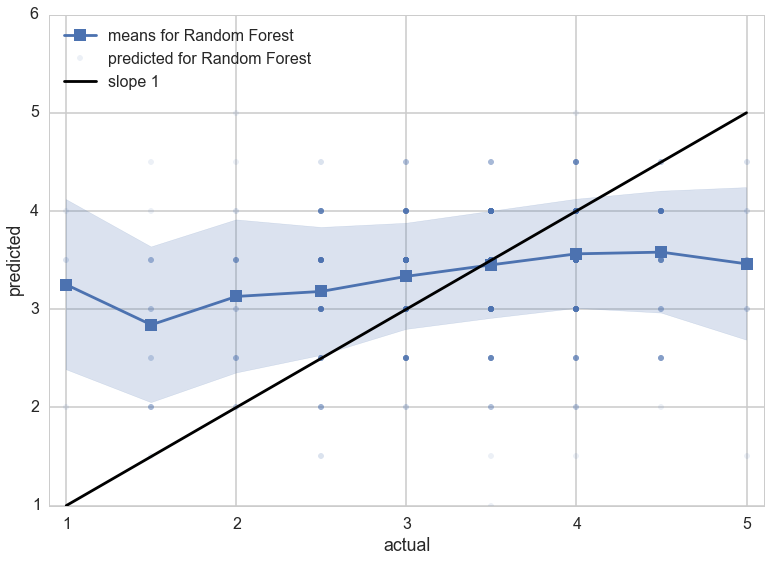

In [75]:
compare_results(testrats, testpred, model = "Random Forest", predicteds = True)
plt.show()

The RMSE of the results are in no way amazing (probably due to the high variance that comes with classification), but the general slope of the means seems to have the right trend, showing that Random Forest does have some strength to it. While we won't be using these predictions later on, we can certainly use this model to see if our new features were useful. To do this, we can make a dictionary `featimp_dict` which stores the feature names as keys and their "importance" as measured by the RF classifer. These can then be sorted to find the most important features:

In [76]:
# used to store model for usage in Google Maps visualization on website
'''
import pickle
with open("../yelpsite/dataset_challenge/static/random_forest.pickle", "w") as f:
    pickle.dump(clf_best, f)
'''

In [77]:
featimp_dict = dict(zip(testdm.columns, clf_best.feature_importances_))
sorted_feats = sorted(featimp_dict, key=featimp_dict.get, reverse=True)

# list of top features and list of corresponding values
top_feats = sorted_feats[:10]
top_vals = [featimp_dict[x] for x in sorted_feats[:10]]

We then make a barplot to visualize the 10 most "important" features using seaborn:

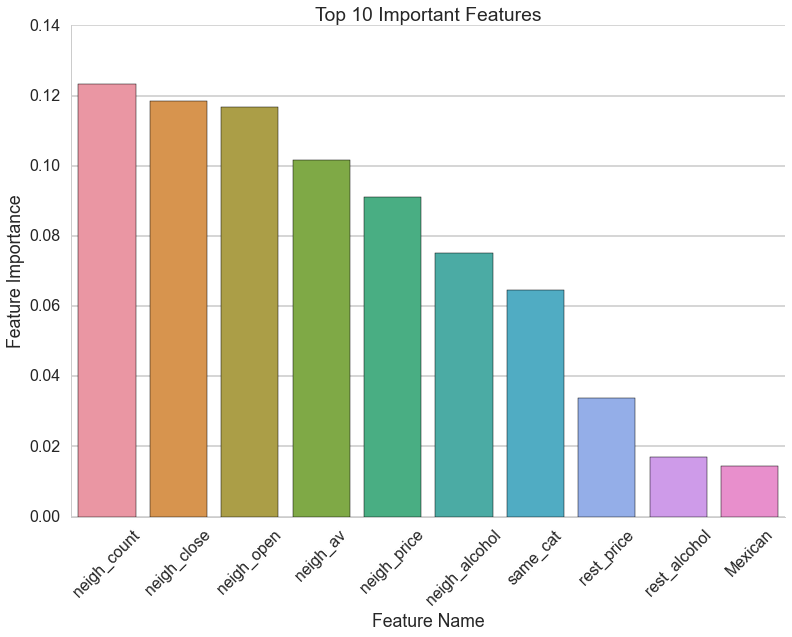

In [80]:
g= sns.barplot(x=top_feats, y=top_vals)

for item in g.get_xticklabels():
    item.set_rotation(45)

g.set(xlabel='Feature Name', ylabel='Feature Importance', title = "Top 10 Important Features")
sns.despine()

It looks like other than `review_count`, the neighborhood attributes seem to be more "important" than the restaurant's attributes themselves! For example, the neighborhood's price is a better predictor of the restaurant's rating than the restaurant's own price. This is a super interesting discovery, and gives us encouragement when looking toward a predictive model that uses such factors. The Random Forest classifier was great for finding some factors that could be helpful, but now let's go back to our Ridge Regression model, this time using a totally different method by using such features.

### Ridge Regression - Using Neighborhood Attributes ###

Now we hope to get our best predictions yet by using the same method, but applying it to a model where our predictions will be continuous. We can do this by running a similar cross-validation loop as we did for the Random Forest: we repeat the method of re-formatting our train/validation/test sets for each value of `k`, and save each test set (which is untouched, other than being formatted) in a dictionary. However, this time we have an extra hyperparameter to loop through and optimize (the alpha value of the Ridge fuction once again). Let's give it one more go:

In [81]:
%%time
alphas = [0.01, 0.1, 10, 100, 1000]
ks = [5, 10, 15, 20, 25]
rdict = {}
vdict = {}
dfdict = {}

# iterate through alpha values

for k in ks:
    
    # format our train, validation, and test sets ---------------------------------------------------------------------
    rest_train_ridge = format_df(rest_train, AZdf, knearest, k).dropna()
    rest_val_ridge = format_df(rest_val, AZdf, knearest, k).dropna()
    rest_test_ridge = format_df(rest_test, AZdf, knearest, k).dropna()

    # organize x and y variables ---------------------------------------------------------------------------------------
    train_rats = rest_train_ridge.stars
    val_rats = rest_val_ridge.stars
    test_rats = rest_test_ridge.stars
    rest_train_ridge.drop('stars', axis=1, inplace=True)
    rest_val_ridge.drop('stars', axis=1, inplace=True)
    rest_test_ridge.drop('stars', axis=1, inplace=True)
    
    # store test dataframes so they can be used later if we want to test our predictions on this value of k ------------
    dfdict[k] = {}
    dfdict[k]['test_x'] = rest_test_ridge
    dfdict[k]['test_y'] = test_rats
    dfdict[k]['val_x'] = rest_val_ridge
    dfdict[k]['val_y'] = val_rats
    
    # carry out regression, going through all possible values of alpha for specific k-----------------------------------
    for a in alphas:
        # fit model on training, predict on validation
        model = Ridge(alpha=a).fit(rest_train_ridge, train_rats)
        valpred = model.predict(rest_val_ridge)
        # store model and RMSE in respective dictionaries
        rdict[(a,k)] = model
        vdict[(a,k)] = get_rmse(val_rats, valpred)

CPU times: user 6min 2s, sys: 5.96 s, total: 6min 8s
Wall time: 6min 56s


In [82]:
minerror=min(vdict, key=vdict.get)
print minerror
regr=rdict[minerror]

(10, 15)


We again find the test set corresponding to the best k value and compare results:

In [83]:
testdm = dfdict[minerror[1]]['test_x']
testrats = dfdict[minerror[1]]['test_y']
testpred = regr.predict(testdm)
testdm.head()

valdm = dfdict[minerror[1]]['val_x']
valrats = dfdict[minerror[1]]['val_y']
valpred = regr.predict(valdm)

predictions['ridge2'] = testpred
predictions_valid['ridge2'] = valpred

RMSE for Complex Ridge Regression 0.679670362638


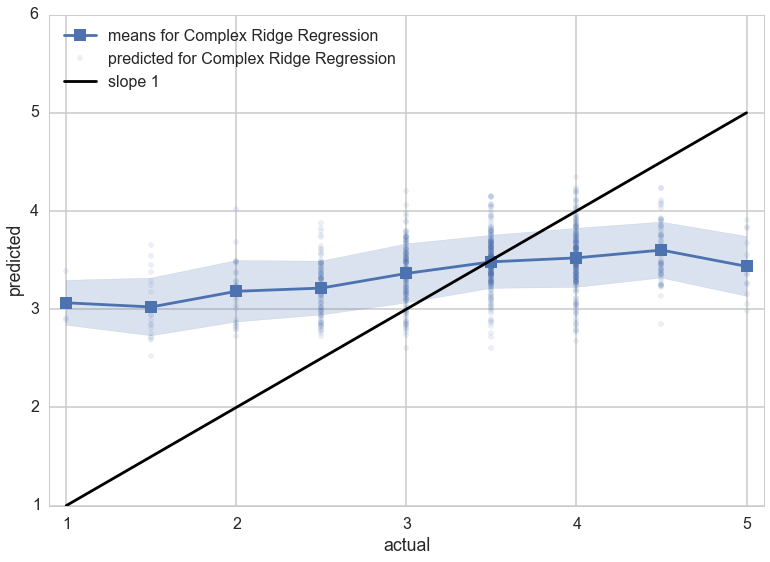

In [84]:
compare_results(testrats, testpred, model = "Complex Ridge Regression", predicteds = True)
plt.show()

In [85]:
# pickle ComplexRidge for later use in Google Maps visualization
'''
import pickle
with open("../yelpsite/dataset_challenge/static/ComplexRidge.pickle", "w") as f:
    pickle.dump(regr, f)
'''

Awesome, our predictions improved a lot! We have a much lower RMSE and an average line that has a bit of a steeper positive slope that is closer to the slope=1 line. This may point to the possible conclusion that neighborhood attributes, such as price range and hours, do in fact play a role in predicting the rating of a certain restaurant, possibly even more so than a restaurant's individual attributes.

### Get at me AdaBoost ###

In [86]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model

Just as we did before, we will again use cross-validation to find our value for k, using a train/validate format. This time, we will use two different regression models; the Decision Tree and AdaBoost Regressors. The Decision Tree regression will essentially run through each variable, splitting the data for each one and calculating the error on the resulting classification. It then goes through all of the splits, finding the one with the smallest squared error and using that in the regression. It continues this process recursively. The AdaBoost regression will fit a regressor on the original dataset and then fit additional copies of the regressor on the same dataset, but with the weights of instances adjusted according to the error of the current prediction.

In [87]:
%%time
ks = [5, 10, 15, 20, 25]

clfdict1 = {}
clfdict2 = {}
vdict1 = {}
vdict2 = {}
dfdict = {}

for k in ks:
    # format our train, validation, and test sets
    rest_train_ada = format_df(rest_train, AZdf, knearest, k).dropna()
    rest_val_ada = format_df(rest_val, AZdf, knearest, k).dropna()
    rest_test_ada = format_df(rest_test, AZdf, knearest, k).dropna()

    # organize x and y variables
    train_rats = rest_train_ada.stars
    val_rats = rest_val_ada.stars
    test_rats = rest_test_ada.stars
    rest_train_ada.drop('stars', axis=1, inplace=True)
    rest_val_ada.drop('stars', axis=1, inplace=True)
    rest_test_ada.drop('stars', axis=1, inplace=True)
    
    # store test dataframes so they can be used later if we want to test our predictions on this value of k
    dfdict[k] = {}
    dfdict[k]['test_x'] = rest_test_ada
    dfdict[k]['test_y'] = test_rats
    dfdict[k]['val_x'] = rest_val_ada
    dfdict[k]['val_y'] = val_rats

    # Fit regression model
    regr_1 = DecisionTreeRegressor(max_depth=4)

    regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                              n_estimators=300)

    regr_1.fit(rest_train_ada, train_rats)
    regr_2.fit(rest_train_ada, train_rats)

    # Predict
    y_1 = regr_1.predict(rest_val_ada)
    y_2 = regr_2.predict(rest_val_ada)

    # store model and RMSE in respective dictionaries
    clfdict1[k] = regr_1
    clfdict2[k] = regr_2
    vdict1[k] = get_rmse(val_rats, y_1)
    vdict2[k] = get_rmse(val_rats, y_2)

CPU times: user 5min 42s, sys: 4.79 s, total: 5min 47s
Wall time: 6min 20s


In [88]:
minerror1=min(vdict1, key=vdict1.get)
minerror2=min(vdict2, key=vdict2.get)

clf_best1=clfdict1[minerror1]
clf_best2=clfdict2[minerror2]

In [89]:
testdm = dfdict[minerror1]['test_x']
testrats = dfdict[minerror1]['test_y']
testpred = clf_best1.predict(testdm)
predictions['decision_tree'] = testpred

valdm = dfdict[minerror1]['val_x']
valrats = dfdict[minerror1]['val_y']
valpred = clf_best1.predict(valdm)
predictions_valid['decision_tree'] = valpred

RMSE for Decision Tree Regression 0.70623586918


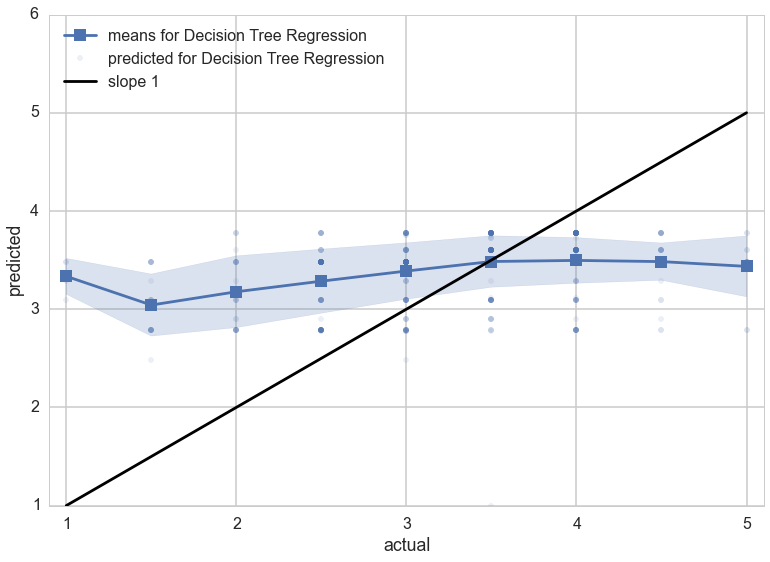

In [90]:
compare_results(testrats, testpred, model = "Decision Tree Regression", predicteds = True)
plt.show()

Just out of curiousity, let's check our most important features here from the Decision Tree Regression.

In [91]:
featimp_dict = dict(zip(testdm.columns, clf_best1.feature_importances_))
sorted_feats = sorted(featimp_dict, key=featimp_dict.get, reverse=True)

# list of top features and list of corresponding values
top_feats = sorted_feats[:10]
top_vals = [featimp_dict[x] for x in sorted_feats[:10]]

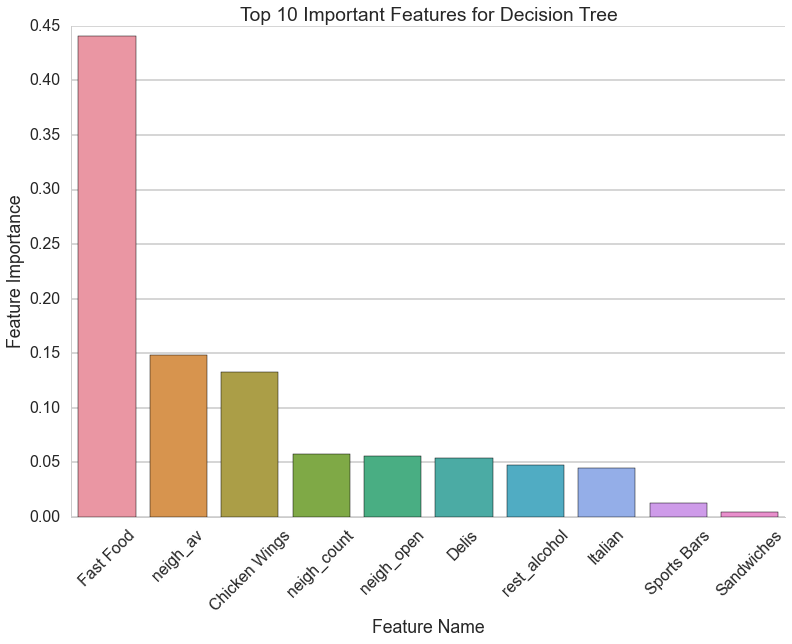

In [92]:
g= sns.barplot(x=top_feats, y=top_vals)

for item in g.get_xticklabels():
    item.set_rotation(45)

g.set(xlabel='Feature Name', ylabel='Feature Importance', title = "Top 10 Important Features for Decision Tree")
sns.despine()

Interestingly, it looks like fast food (and related things like wings and sports bars) dominate the important features when we use Decision Tree Regression! This will have interesting consequences on our predictions because using the Decision Tree Regression will probably give very different results in high-end neighborhoods than our ridge regression above. 

In [93]:
testdm = dfdict[minerror1]['test_x']
testrats = dfdict[minerror1]['test_y']
testpred = clf_best2.predict(testdm)
predictions['adaboost'] = testpred

valdm = dfdict[minerror1]['val_x']
valrats = dfdict[minerror1]['val_y']
valpred = clf_best2.predict(valdm)
predictions_valid['adaboost'] = valpred

RMSE for AdaBoost Regression 0.704942852209


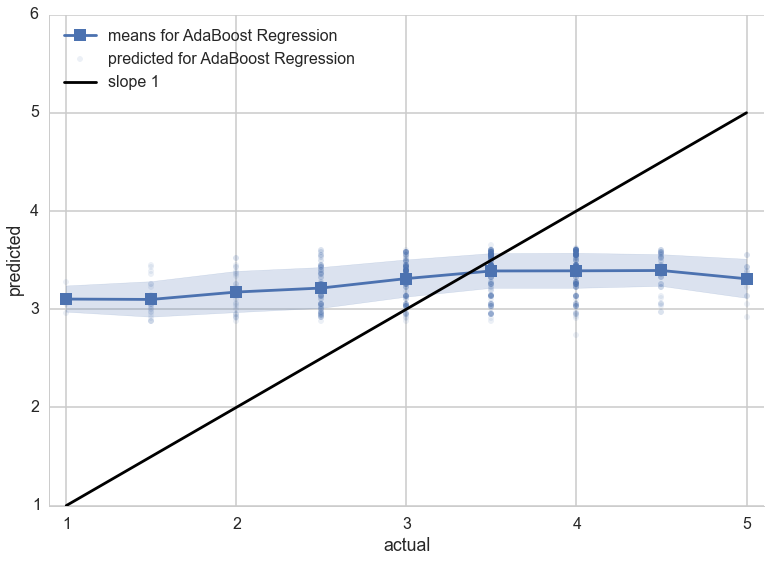

In [94]:
compare_results(testrats, testpred, model = "AdaBoost Regression", predicteds = True)
sns.despine()

In [95]:
featimp_dict = dict(zip(testdm.columns, clf_best2.feature_importances_))
sorted_feats = sorted(featimp_dict, key=featimp_dict.get, reverse=True)

# list of top features and list of corresponding values
top_feats = sorted_feats[:10]
top_vals = [featimp_dict[x] for x in sorted_feats[:10]]

Again, let's check the imporant features. 

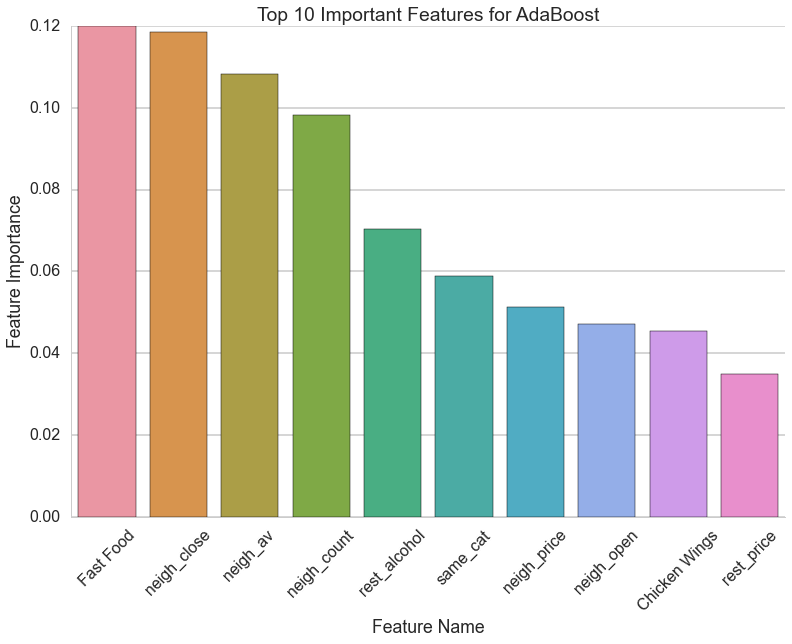

In [96]:
g= sns.barplot(x=top_feats, y=top_vals)

for item in g.get_xticklabels():
    item.set_rotation(45)

g.set(xlabel='Feature Name', ylabel='Feature Importance', title = "Top 10 Important Features for AdaBoost")
sns.despine()

This seems a lot more similar to the Ridge Regression.

Ultimately, the Decision Tree and AdaBoost Regressions both gave us RMSEs just slightly higher than the complex Ridge Regression. However, we saw that the Decision Tree had very different important features, which might lead to different predictions between the two models if there is a lot of fast food (or a lack of fast food) in the neighborhood). It will be interesting to see how this turns out when we implement it in our map. 

##Ensemble Method: Blending Local, Simple Ridge, & Complex Ridge ##

In [97]:
predictions.keys()

['decision_tree', 'ridge1', 'adaboost', 'ridge2']

Before we can make our ensemble Dataframe, we need to make the predictions equal lengths. We may have removed some NaN values from our data frame when making the 'ridge2' predictions (depending on what k value we get from the cross validation), so let's go back and find those null values. We will find the rows that were removed from the data frame, then we will remove the same rows from the 'ridge1' predictions.


In [98]:
formatteddf = format_df(rest_test, AZdf, knearest, minerror[1])
len(formatteddf[formatteddf.isnull().any(axis=1)])

0

In [99]:
formatteddf_valid = format_df(rest_val, AZdf, knearest, minerror[1])
len(formatteddf_valid[formatteddf_valid.isnull().any(axis=1)])

0

This shows how many rows we removed when doing the 'ridge2' predictions from the test and validation sets. If the above numbers are 0, it means we didn't remove any. This number will change depending on what k gets chosen during cross validation, so we will go ahead and run the following code in any situation. Let's find those rows and remove the corresponding predictions from 'ridge1'.


In [100]:
null_rows_valid = formatteddf_valid[formatteddf_valid.isnull().any(axis=1)].index
null_rows = formatteddf[formatteddf.isnull().any(axis=1)].index

In [101]:
predictions_valid['ridge1'] = np.delete(predictions_valid['ridge1'], null_rows_valid)
predictions['ridge1'] = np.delete(predictions['ridge1'], null_rows)

Now we can go ahead and make the data frame for the validation and test predictions. Essentially, we are making a data frame with the actual rating of the validation set in one column, and the predicted ratings for that id in the other columns. We will then run a linear regression to find the correct weightings for each model, and use these weightings to make our ensemble prediction on the test data.


In [102]:
dfensemblevalid=pd.DataFrame.from_dict({'ridge1':predictions_valid['ridge1'],
                                   'ridge2':predictions_valid['ridge2'],
                                    'decision_tree':predictions_valid['decision_tree'],
                                    'adaboost':predictions_valid['adaboost'],
                                   'y':valrats})

In [103]:
dfensembletest=pd.DataFrame.from_dict({'ridge1':predictions['ridge1'],
                                   'ridge2':predictions['ridge2'], 
                                    'decision_tree':predictions['decision_tree'],
                                    'adaboost':predictions['adaboost'],
                                   'y':testrats})

In [104]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
valreg = lm.fit(dfensemblevalid.drop('y',axis=1),dfensemblevalid['y'])

There are our data frames and linear regression to determine the weightings. Here is the ensemble prediction using those weightings.


In [105]:
ensemble_predictions = valreg.predict(dfensembletest.drop('y',axis=1))
testactual = dfensembletest['y']

RMSE for ensemble 0.679336158298


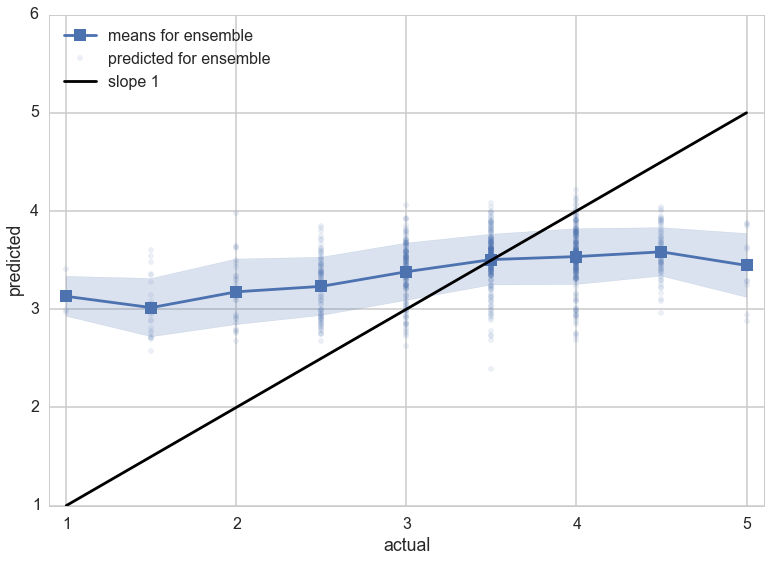

In [106]:
ax=compare_results(testactual, ensemble_predictions, model="ensemble", predicteds=True);
plt.show()